
# Advanced Data Science Capstone Coursera/IBM:
# Air pollution and prevalence of bronchial asthma in Germany 

## 0 The Task
The aim of the present study is understanding of correlation between air quality and prevalence of bronchial asthma in Germany. Using public available data for air quality measurements a classification model will be built. The German counties will be classified to be a high-risk or low-risk of the disease.

## 1 Exploratory research

## 1.1 Data sources
As data sources I use the data sets officially published by **Geschäfts- und Koordinierungsstelle GovData**, the search engine is available at https://www.govdata.de/web/guest/suchen.
The list of relevant data sets is following:

### 1.1.1 Air quality:

Data stream **E1a** contains measured (Link to Data stream D) values of gas phase pollutants (e.g. Ozone, NO2, SO2, CO), particle pollutants (e.g. dust) and dust constituants (e.g. heavy metals, PAK in PM10, PM2.5, TSP) as well es total deposition (BULK), wet deposition and meteorologic data (e.g. temperature, wind, pressure)for every measurement location.

The data for years 2013 - 2018 is available. For the exploratory research I will limit myself with 2016 data,
since there are no principal difference with the other years data. Some examples of access to 2017 and 2018 year data are also shown in the present notebook.

Compressed dataset is available at https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2016.zip.

 - Air quality data (Datastream E1a) - Validated measurements from 2016 (Dataset).
   - Metadata in RDF format: https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-e1a-validierte-einzelwerte-2016-datensatz.rdf .
   - ATOM: Air quality data (INSPIRE Download/Atom Feed): https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Service_5e7bb800-c1db-4343-ac3e-a63204b0f6b7.atom.xml (currently N/A, *Invalid URL, Code: 400*)
   - XML-Metadata: Air quality data (Datastream E1a) - Validated measurements from 2016: http://www.geoportal.de/gds/xml.php?uuid=03e2d1ac-70dd-4664-8a46-9f5f6b756fe1
   
 - Positions of the air quality sensors (Datastream D): https://www.govdata.de/ckan/dataset/luftqualitatsdaten-datenstrom-d-beurteilungsmethoden-2016-datensatz.rdf.
 
### 1.1.2 Health indicator data
   - Bronchial asthma prevalence: https://www.versorgungsatlas.de/fileadmin/excel/data_id_92_kreis11_1_j_1451606400.xlsx contains county-based data on prevalence of bronchial asthma (in percent of population) for year 2016.
   - Also the data for other diseases and years (no complete coverage), as well as Self-evaluation of the health status, on the county-averaged basis can be found at this site.
   
### 1.1.3 Auxiliary information
   - In order to connect the datasets from different origin one need to have geotagging in the same format.
The easiest way is to stick on county-based data, attribute all air pollution sensors positions to corresponding counties. 
   - The data set containing the information on German towns and counties can be found at https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile.

## 1.2 Initial Data Exploration
 - Load the data sets and check it's structure, size and data quality (non-informative entries, data variability)
 - If the data set is big, make a sample subset
 - Make exploratory plots
  
### 1.2.1 Loading all necessary libraries:

In [2]:
###import rdfpandas as pd
#!pip install rdflib
#!pip install networkx
#!pip install xlrd

import urllib.request
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import numpy as np

import re, collections
from io import StringIO
import os, fnmatch

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import tensorflow as tf
import shutil

### 1.2.2 Creating an auxiliary functions for treating XML files
It will be useful, since almost all data at GovData.de is in the *xml* format. The function for printing XML file structure in human readable form:

In [3]:
def PrintXML(XMLfileName):
    xml_root = (etree.parse(XMLfileName)).getroot()
    raw_tree = etree.ElementTree(xml_root)
    nice_tree = collections.OrderedDict()

    for tag in xml_root.iter():
        path = re.sub('\[[0-9]+\]', '', raw_tree.getpath(tag))
        if path not in nice_tree:
            nice_tree[path] = []
        if len(tag.keys()) > 0:
            nice_tree[path].extend(attrib for attrib in tag.keys() if attrib not in nice_tree[path])            
 
    for path, attribs in nice_tree.items():
        indent = int(path.count('/') - 1)
        print('{0}{1}: {2} [{3}]'.format('    ' * indent, indent, path.split('/')[-1], ', '.join(attribs) 
                                         if len(attribs) > 0 else '-'))

The function for obtaining all tags for given XML file (returns list of tags):

In [4]:
def GetAllTags(XMLfileName):
    Etree = ET.parse(XMLfileName)
    Eroot = Etree.getroot()
#   Eroot.tag
#   Eroot.attrib
    AllTags = [elem.tag for elem in Eroot.iter()]
    return(AllTags)

### 1.2.3 Downloading the data
The pollutant concentration data set, it's metadata file, sensor position data set (town-name based) and town-county data sets are downloaded from the web. Blocks for downloading the air pollution data sets for years 2017 and 2018 are commented out, however they are fully functional.  

In [4]:
!rm -rf ./Capstone.rawData
## Download and decompress the dataset itself:
!mkdir Capstone.rawData
!ls -l Capstone.rawData/

##### Pollution 2016
!mkdir Capstone.rawData/AQD_DE_E1a_2016
urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2016.zip", "Capstone.rawData/AQD_DE_E1a_2016.zip")
!mv Capstone.rawData/AQD_DE_E1a_2016.zip Capstone.rawData/AQD_DE_E1a_2016/
!unzip Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip -d Capstone.rawData/
!rm Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip

##### Pollution 2017
#!mkdir Capstone.rawData/AQD_DE_E1a_2017
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2017.zip", "Capstone.rawData/AQD_DE_E1a_2017.zip")
#!mv Capstone.rawData/AQD_DE_E1a_2017.zip Capstone.rawData/AQD_DE_E1a_2017/
#!unzip Capstone.rawData/AQD_DE_E1a_2017/AQD_DE_E1a_2017.zip -d Capstone.rawData/
#!rm Capstone.rawData/AQD_DE_E1a_2017/AQD_DE_E1a_2017.zip
#!unzip Capstone.rawData/AQD_DE_E1a_2017/DISKO.zip -d Capstone.rawData/AQD_DE_E1a_2017/
#!unzip Capstone.rawData/AQD_DE_E1a_2017/KONTI.zip -d Capstone.rawData/AQD_DE_E1a_2017/
#!rm Capstone.rawData/AQD_DE_E1a_2017/DISKO.zip Capstone.rawData/AQD_DE_E1a_2017/KONTI.zip

##### Pollution 2018
#!mkdir Capstone.rawData/AQD_DE_E1a_2018
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_E1a_2018.zip", "Capstone.rawData/AQD_DE_E1a_2018.zip")
#!mv Capstone.rawData/AQD_DE_E1a_2018.zip Capstone.rawData/AQD_DE_E1a_2018/
#!unzip Capstone.rawData/AQD_DE_E1a_2018/AQD_DE_E1a_2018.zip -d Capstone.rawData/
#!rm Capstone.rawData/AQD_DE_E1a_2018/AQD_DE_E1a_2018.zip
#!mv ./Capstone.rawData/E1a/* Capstone.rawData/AQD_DE_E1a_2018/
#!rm -rf Capstone.rawData/E1a

##Download the dataset Metadata xml
urllib.request.urlretrieve("http://www.geoportal.de/gds/xml.php?uuid=03e2d1ac-70dd-4664-8a46-9f5f6b756fe1", "Capstone.rawData/AQD_DE_E1a_2016/E1a2016_meta.xml")
#urllib.request.urlretrieve("http://www.geoportal.de/gds/xml.php?uuid=cdadb71f-5571-4c95-af2a-d926efb4e3a0", "Capstone.rawData/AQD_DE_E1a_2018/E1a2018_meta.xml")
#urllib.request.urlretrieve("http://www.geoportal.de/gds/xml.php?uuid=c533b9a5-e518-4bf8-9a0a-1b829acd561d", "Capstone.rawData/AQD_DE_E1a_2017/E1a2017_meta.xml") 

##Download Sensor positions
#urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_D_2017.zip", "Capstone.rawData/AQD_DE_D_2017.zip")
#!unzip Capstone.rawData/AQD_DE_D_2017.zip -d Capstone.rawData/
#!rm Capstone.rawData/AQD_DE_D_2017.zip
urllib.request.urlretrieve("https://datahub.uba.de/server/rest/directories/arcgisforinspire/INSPIRE/aqd_MapServer/Daten/AQD_DE_D_2016.zip", "Capstone.rawData/AQD_DE_D_2016.zip")
!unzip Capstone.rawData/AQD_DE_D_2016.zip -d Capstone.rawData/
!rm Capstone.rawData/AQD_DE_D_2016.zip


## Download Town-county dataset:
urllib.request.urlretrieve("https://www.destatis.de/DE/Themen/Laender-Regionen/Regionales/Gemeindeverzeichnis/Administrativ/Archiv/GV100ADQ/GV100AD3107.zip?__blob=publicationFile",
                           "Capstone.rawData/GV100AD3107.zip")
!mkdir Capstone.rawData/GV100AD3107
!unzip Capstone.rawData/GV100AD3107.zip -d Capstone.rawData/GV100AD3107/
!rm Capstone.rawData/GV100AD3107.zip


#!ls -la Capstone.rawData/AQD_DE_E1a_2017/
#!pwd

Archive:  Capstone.rawData/AQD_DE_E1a_2016/AQD_DE_E1a_2016.zip
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NOx_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_O3_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM1_day.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM1_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM2_day.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_PM2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_SO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_CO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_NO2_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_NO_hour.xml  
  inflating: Capstone.rawData/AQD_DE_E1a_2016/DE_SL_2016_O3_hour.xml  
  inflat

### 1.2.4 Examine metadata XML file
Now let's take a look at the downloaded *E1a2016_meta.xml* file.
First print it's structure

In [5]:
PrintXML("Capstone.rawData/AQD_DE_E1a_2016/E1a2016_meta.xml")

0: gmd:MD_Metadata [{http://www.w3.org/2001/XMLSchema-instance}schemaLocation]
    1: gmd:fileIdentifier [-]
        2: gco:CharacterString [-]
    1: gmd:language [-]
        2: * [codeList, codeListValue]
    1: gmd:characterSet [-]
        2: * [codeList, codeListValue]
    1: gmd:hierarchyLevel [-]
        2: * [codeList, codeListValue]
    1: gmd:hierarchyLevelName [-]
        2: gco:CharacterString [-]
    1: gmd:contact [-]
        2: gmd:CI_ResponsibleParty [-]
            3: gmd:individualName [-]
                4: gco:CharacterString [-]
            3: gmd:organisationName [-]
                4: gco:CharacterString [-]
            3: gmd:positionName [-]
                4: gco:CharacterString [-]
            3: gmd:contactInfo [-]
                4: gmd:CI_Contact [-]
                    5: gmd:phone [-]
                        6: gmd:CI_Telephone [-]
                            7: gmd:voice [-]
                                8: gco:CharacterString [-]
                     

This give us almost no information about the dataset.
Finally, printing out parsed *xml* file (it is not so big, just 37 kB, for code see commented chunk below) I found
that it contains urls to data formats and standards: http://standards.iso.org/ittf/PubliclyAvailableStandards/ISO_19139_Schemas/resources/codelist/ML_gmxCodelists.xml#CI_DateTypeCode, https://registry.gdi-de.org/id/de.bund.uba.inspire.aqd/cdadb71f-5571-4c95-af2a-d926efb4e3a0, etc. Also it contains description of the measurement procedure details, that are out of the current study scope.

Since the data will be normailzed during feature creation process, the only important thing is that **all the data sets are using the same units**. However the units of measurements are also mentioned in the data files themselves, as it will be shown later, so these **metadata files contain no information useful for the current study**.

In [6]:
#### This code prints entire parsed xml file
#import xml.dom.minidom
#with open('Capstone.rawData/AQD_DE_E1a_2018/E1a2018_meta.xml', encoding='utf-8') as xmldata:
#    xml = xml.dom.minidom.parseString(xmldata.read())  # or xml.dom.minidom.parseString(xml_string)
#    xml_pretty_str = xml.toprettyxml()
#print(xml_pretty_str)

### 1.2.5 Dataset files analysis
Let's take a look at the downloaded data set:

In [7]:
!ls -la Capstone.rawData/AQD_DE_E1a_2016/

total 594480
drwxr-xr-x  65 gorelov  staff      2080 Apr 23 10:55 .
drwxr-xr-x   6 gorelov  staff       192 Apr 23 10:55 ..
-rw-r--r--   1 gorelov  staff   6803692 Apr 19  2018 DE_SH_2016_NO2_hour.xml
-rw-r--r--   1 gorelov  staff   6712715 Apr 19  2018 DE_SH_2016_NO_hour.xml
-rw-r--r--   1 gorelov  staff   6802174 Apr 19  2018 DE_SH_2016_NOx_hour.xml
-rw-r--r--   1 gorelov  staff   5673016 Apr 19  2018 DE_SH_2016_O3_hour.xml
-rw-r--r--   1 gorelov  staff    125170 Apr 19  2018 DE_SH_2016_PM1_day.xml
-rw-r--r--   1 gorelov  staff   3954075 Apr 19  2018 DE_SH_2016_PM1_hour.xml
-rw-r--r--   1 gorelov  staff     64316 Apr 19  2018 DE_SH_2016_PM2_day.xml
-rw-r--r--   1 gorelov  staff   3927142 Apr 19  2018 DE_SH_2016_PM2_hour.xml
-rw-r--r--   1 gorelov  staff    557581 Apr 19  2018 DE_SH_2016_SO2_hour.xml
-rw-r--r--   1 gorelov  staff   1658891 Apr 19  2018 DE_SL_2016_CO_hour.xml
-rw-r--r--   1 gorelov  staff   5028403 Apr 19  2018 DE_SL_2016_NO2_hour.xml
-rw-r--r--   1 gorelov  staff   49

It is clear, that filenames contain information on the file contents:
e.g. **DE_SH_2016_NOx_hour.xml**: **DE** for Germany, **SH** for Schleswig-Holstein state, **2016** for year of measurements, **NOx** for kind of pollutant (nitrogen oxides), **hour** for type of measurements (hourly average).  

Now let's take a look at the *DE_SH_2016_NOx_hour.xml* file structure:

In [6]:
XMLfileToExplore = "Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NOx_hour.xml"
PrintXML(XMLfileToExplore)


0: gml:FeatureCollection [{http://www.w3.org/2001/XMLSchema-instance}schemaLocation, {http://www.opengis.net/gml/3.2}id]
    1: gml:featureMember [-]
        2: om:OM_Observation [{http://www.opengis.net/gml/3.2}id]
            3: om:phenomenonTime [-]
                4: gml:TimePeriod [{http://www.opengis.net/gml/3.2}id]
                    5: gml:beginPosition [-]
                    5: gml:endPosition [-]
            3: om:resultTime [-]
                4: gml:TimeInstant [{http://www.opengis.net/gml/3.2}id]
                    5: gml:timePosition [-]
            3: om:procedure [{http://www.w3.org/1999/xlink}href]
            3: om:parameter [-]
                4: om:NamedValue [-]
                    5: om:name [{http://www.w3.org/1999/xlink}href]
                    5: om:value [{http://www.w3.org/1999/xlink}href, {http://www.w3.org/2001/XMLSchema-instance}type]
            3: om:observedProperty [{http://www.w3.org/1999/xlink}href]
            3: om:featureOfInterest [{http://ww

Again, a number of url's describing various standards, however the structure of file becomes clear.
Let's check the first rank entries from the root:

In [9]:
xml_tree = etree.parse(XMLfileToExplore)
xml_root = xml_tree.getroot()
for child in xml_root:
    print(child.tag, child.attrib) 

{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}
{http://www.opengis.net/gml/3.2}featureMember {}


It looks like  that the *DE_SH_2016_NOx_hour.xml* file contains measurements from 13 sensors at different locations (as it will be shown later, the file contains only 12 sensors data, and the first entry is used for auxiliary information). 
An *xml* file entry consist of three possible elements: **tag**, like key or variable name; **attrib**, like value of variable, and **text**, that accommodates everything between corresponding tags (up to video in *base64* encoding). Few tags of the XML pollutant concentration file can be printed out: 

In [7]:
AllTagsPollutantConcHour = GetAllTags(XMLfileToExplore)
print(*AllTagsPollutantConcHour[5:16], sep="\n")

#varName = 'value'
#print("\n".join([s for s in AllTagsPollutantConcHour if varName in s])) 

{http://www.opengis.net/gml/3.2}beginPosition
{http://www.opengis.net/gml/3.2}endPosition
{http://www.opengis.net/om/2.0}resultTime
{http://www.opengis.net/gml/3.2}TimeInstant
{http://www.opengis.net/gml/3.2}timePosition
{http://www.opengis.net/om/2.0}procedure
{http://www.opengis.net/om/2.0}parameter
{http://www.opengis.net/om/2.0}NamedValue
{http://www.opengis.net/om/2.0}name
{http://www.opengis.net/om/2.0}value
{http://www.opengis.net/om/2.0}parameter


In [8]:
# pick all tags from the XML file
Etree = ET.parse("Capstone.rawData/AQD_DE_E1a_2016/DE_SH_2016_NOx_hour.xml")
Eroot = Etree.getroot()
Eroot.tag
Eroot.attrib
AllTags = [elem.tag for elem in Eroot.iter()]
print(AllTags[23:35])
#varName = 'observedProperty'
#print("\n".join([s for s in AllTags if varName in s]))    

['{http://www.isotc211.org/2005/gmd}result', '{http://www.isotc211.org/2005/gmd}DQ_ConformanceResult', '{http://www.isotc211.org/2005/gmd}specification', '{http://www.isotc211.org/2005/gmd}CI_Citation', '{http://www.isotc211.org/2005/gmd}title', '{http://www.isotc211.org/2005/gco}CharacterString', '{http://www.isotc211.org/2005/gmd}date', '{http://www.isotc211.org/2005/gmd}CI_Date', '{http://www.isotc211.org/2005/gmd}date', '{http://www.isotc211.org/2005/gco}Date', '{http://www.isotc211.org/2005/gmd}dateType', '{http://www.isotc211.org/2005/gmd}CI_DateTypeCode']


### 1.2.6 Exploring Dataset XML structure
First of all, let's write auxiliary functions, that will fetch *xml* tags containing given keyword.
The ideas about keywords can be obtained looking at the *AllTagsPollutantConcHour* list prepared during the previous step.
The function *FetchAllXMLsensor* parse the sensor ID from the corresponding *xml* **attr**
at the **value** tag.

In [9]:
def FetchXMLentryByWord(XMLfileName, varName, NumToPrint, AllTags):
    Eroot = ET.parse(XMLfileName).getroot()
    SelectedEntryNames = [s for s in AllTags if varName in s][NumToPrint]
    print(SelectedEntryNames)
    print([(varr.attrib, varr.text) for varr in Eroot.iter(SelectedEntryNames)][NumToPrint])
    print('\n')
def FetchAllXMLsensorID(XMLfileName, AllTags):
    Eroot = ET.parse(XMLfileName).getroot()
    SelectedEntryNames = [s for s in AllTags if 'value' in s][0]
    print([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) 
           for varr in Eroot.iter(SelectedEntryNames) if 'AQD' in str(varr.attrib)]) 
    print('\n')
def SelectAllXMLsensorID(XMLfileName, AllTags):
    Eroot = ET.parse(XMLfileName).getroot()
    varFull = [s for s in AllTags if 'value' in s][0]
    return([re.sub(r'[^a-zA-Z0-9:]*\'{http(.*)$', r'', re.sub(r'^.*AQD\/SPO.DE_', r'', str(varr.attrib))) 
            for varr in Eroot.iter(varFull) if 'AQD' in str(varr.attrib)]) 
    

Using the *Fetch* functions one can show that the units of measurements in this *xml* file are **microgramm pro cubic meter**, the pollutant is of type 9 (according to the given url it is **NOX as NO2**)  and observation time is an **hour**. 

In [10]:
# Obtaining web links to some useful information on the data set:
FetchXMLentryByWord(XMLfileToExplore, 'Quantity', 0, AllTagsPollutantConcHour)
FetchXMLentryByWord(XMLfileToExplore, 'uom', 2, AllTagsPollutantConcHour)    
FetchXMLentryByWord(XMLfileToExplore, 'observedProperty', 0, AllTagsPollutantConcHour)    

{http://www.opengis.net/swe/2.0}Quantity
({'definition': 'http://dd.eionet.europa.eu/vocabulary/aq/primaryObservation/hour'}, '\n                ')


{http://www.opengis.net/swe/2.0}uom
({'{http://www.w3.org/1999/xlink}href': 'http://dd.eionet.europa.eu/vocabulary/uom/concentration/ug.m-3'}, None)


{http://www.opengis.net/om/2.0}observedProperty
({'{http://www.w3.org/1999/xlink}href': 'http://dd.eionet.europa.eu/vocabulary/aq/pollutant/9'}, None)




Checking the links abow the following information can be found:
- Quantity: The hourly average or hour mean is the average of all valid minute values for an hour. An hourly average is calculated if at least 45 valid minutes values are available.
- uom: Micrograms per cubic meter
- observedProperty: Nitrogen oxides (air), NOX as NO2


Parsing the sensor IDs the following form of IDs is found: **DESH008_NOx_dataGroup1**,
where **DE** stands for Germany, **SH** for Schleswig-Holstein region, **008** is the sensor number (this information will be used later for geotagging), **NOx** for kind of pollutant (nitrogen oxides), and the **dataGroup1** is some common suffix (it is the same for all available data sets):

In [11]:
FetchAllXMLsensorID(XMLfileToExplore, AllTagsPollutantConcHour)

['DESH008_NOx_dataGroup1', 'DESH022_NOx_dataGroup1', 'DESH023_NOx_dataGroup1', 'DESH025_NOx_dataGroup1', 'DESH027_NOx_dataGroup1', 'DESH028_NOx_dataGroup1', 'DESH030_NOx_dataGroup1', 'DESH033_NOx_dataGroup1', 'DESH035_NOx_dataGroup1', 'DESH052_NOx_dataGroup1', 'DESH053_NOx_dataGroup1', 'DESH055_NOx_dataGroup1']




The pollutant concentration data is stored in **text** fields of the entries with **value** tag; the data is stored in the *csv* format, end line symbol is "@@":

In [12]:
# Figure out the data storage format
FetchXMLentryByWord(XMLfileToExplore, 'TextEncoding', 0, AllTagsPollutantConcHour)

{http://www.opengis.net/swe/2.0}TextEncoding
({'decimalSeparator': '.', 'tokenSeparator': ',', 'blockSeparator': '@@'}, None)




### 1.2.7 Exploring pollutant concentration measurements data
For exploratory analysis the **Pandas** library is used. The **text** fields of the entries with **value** tag are parsed as a *csv* file and stored as list of Pandas DataFrames:

In [13]:
AllTagsExplore = GetAllTags(XMLfileToExplore)
valuesExplore = [s for s in AllTagsExplore if 'values' in s][0]

PollutantConcentrationsExplore=[]
for ivalue in Eroot.iter(valuesExplore):
    PollutantConcentrationsExplore.append(pd.read_csv(StringIO((ivalue.text).replace("@@","\n")),
                                                          sep=",", header=None))

The list contains 12 DataFrames of the same dimensionality 8784 x 5:

In [14]:
[PollutantConcentrationsExplore[s].shape for s in range(0,len(PollutantConcentrationsExplore))]

[(8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5),
 (8784, 5)]

In [15]:
PollutantConcentrationsExplore[11].tail(5)

,0,1,2,3,4
8779,2016-12-31T19:00:00+01:00,2016-12-31T20:00:00+01:00,1,1,49.092
8780,2016-12-31T20:00:00+01:00,2016-12-31T21:00:00+01:00,1,1,43.717
8781,2016-12-31T21:00:00+01:00,2016-12-31T22:00:00+01:00,1,1,46.305
8782,2016-12-31T22:00:00+01:00,2016-12-31T23:00:00+01:00,1,1,43.993
8783,2016-12-31T23:00:00+01:00,2016-12-31T24:00:00+01:00,1,1,43.253


From the chunks above one can see that the **DE_SH_2016_NOx_hour.xml** file contains measurements from 12 sensors, each containing **8784 = 8760 + 24** values - one measurement for each hour of the year (2016 was a **leap year**). Columns **0, 1** contains start and end of observation period, and the pollutant concentration is stored in column **4**.

At least in the current file there are no NA values:

In [16]:
sum([PollutantConcentrationsExplore[s].isnull().sum() for s in range(0,len(PollutantConcentrationsExplore))])

0    0
1    0
2    0
3    0
4    0
dtype: int64

The pollutant concentration for two given sensors of the explored data set can be plotted as time series:

In [41]:
#PollutantConcentrationsExplore[11][740:780]

<Figure size 432x288 with 0 Axes>

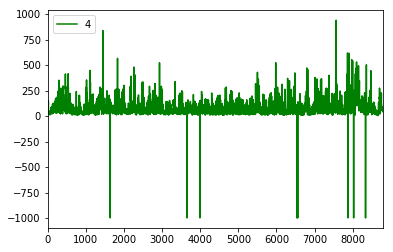

In [40]:
plt.figure()
#(((PollutantConcentrationsExplore[0])[[4]])[740:760]).plot()
((PollutantConcentrationsExplore[11])[[4]]).plot(style='g')


From the figures above it is clear that the data contains also **failed measurements, encoded as negative values** (pollutant concentration cannot be negative). It means that *imputting* strategy should be developed in order to treat the problem. At the moment these negative values will be replaced with zeros, it will cause no problem for initial exploratory analysis. Additionally the list of separate DataFrames for individual sensors will be merged to single DataFrame including hourly values of NOx concentrations for all sensors located in the state of Schleswig-Holstein, adding correct column names:

In [21]:
PollutantConcentrationsState = pd.concat([PollutantConcentrationsExplore[s][4] 
                                          for s in range(0,len(PollutantConcentrationsExplore))], axis=1)

PollutantConcentrationsState.columns = SelectAllXMLsensorID(XMLfileToExplore, AllTagsPollutantConcHour)

PollutantConcentrationsState = PollutantConcentrationsState.clip(lower=0)

PollutantConcentrationsState.tail(3)

,DESH008_NOx_dataGroup1,DESH022_NOx_dataGroup1,DESH023_NOx_dataGroup1,DESH025_NOx_dataGroup1,DESH027_NOx_dataGroup1,DESH028_NOx_dataGroup1,DESH030_NOx_dataGroup1,DESH033_NOx_dataGroup1,DESH035_NOx_dataGroup1,DESH052_NOx_dataGroup1,DESH053_NOx_dataGroup1,DESH055_NOx_dataGroup1
8781,24.993,45.805,35.333,40.718,0.0,46.306,49.205,27.278,29.134,32.706,51.115,46.305
8782,23.295,41.675,35.034,42.768,0.0,50.980,55.622,24.901,33.050,29.609,51.152,43.993
8783,22.493,44.470,34.885,44.806,0.0,45.797,63.197,22.659,42.115,27.448,54.161,43.253


Now we can plot **all pollutant concentration data** from the **DE_SH_2016_NOx_hour.xml** file as a time series: 

<Figure size 2592x1296 with 0 Axes>

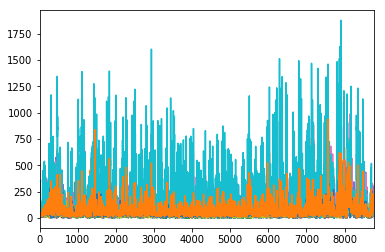

In [22]:
plt.figure(figsize=(36,18))
PollutantConcentrationsState.plot(legend=None)

A summary over the year with respect to **all sensors** from the **DE_SH_2016_NOx_hour.xml** file can be done:

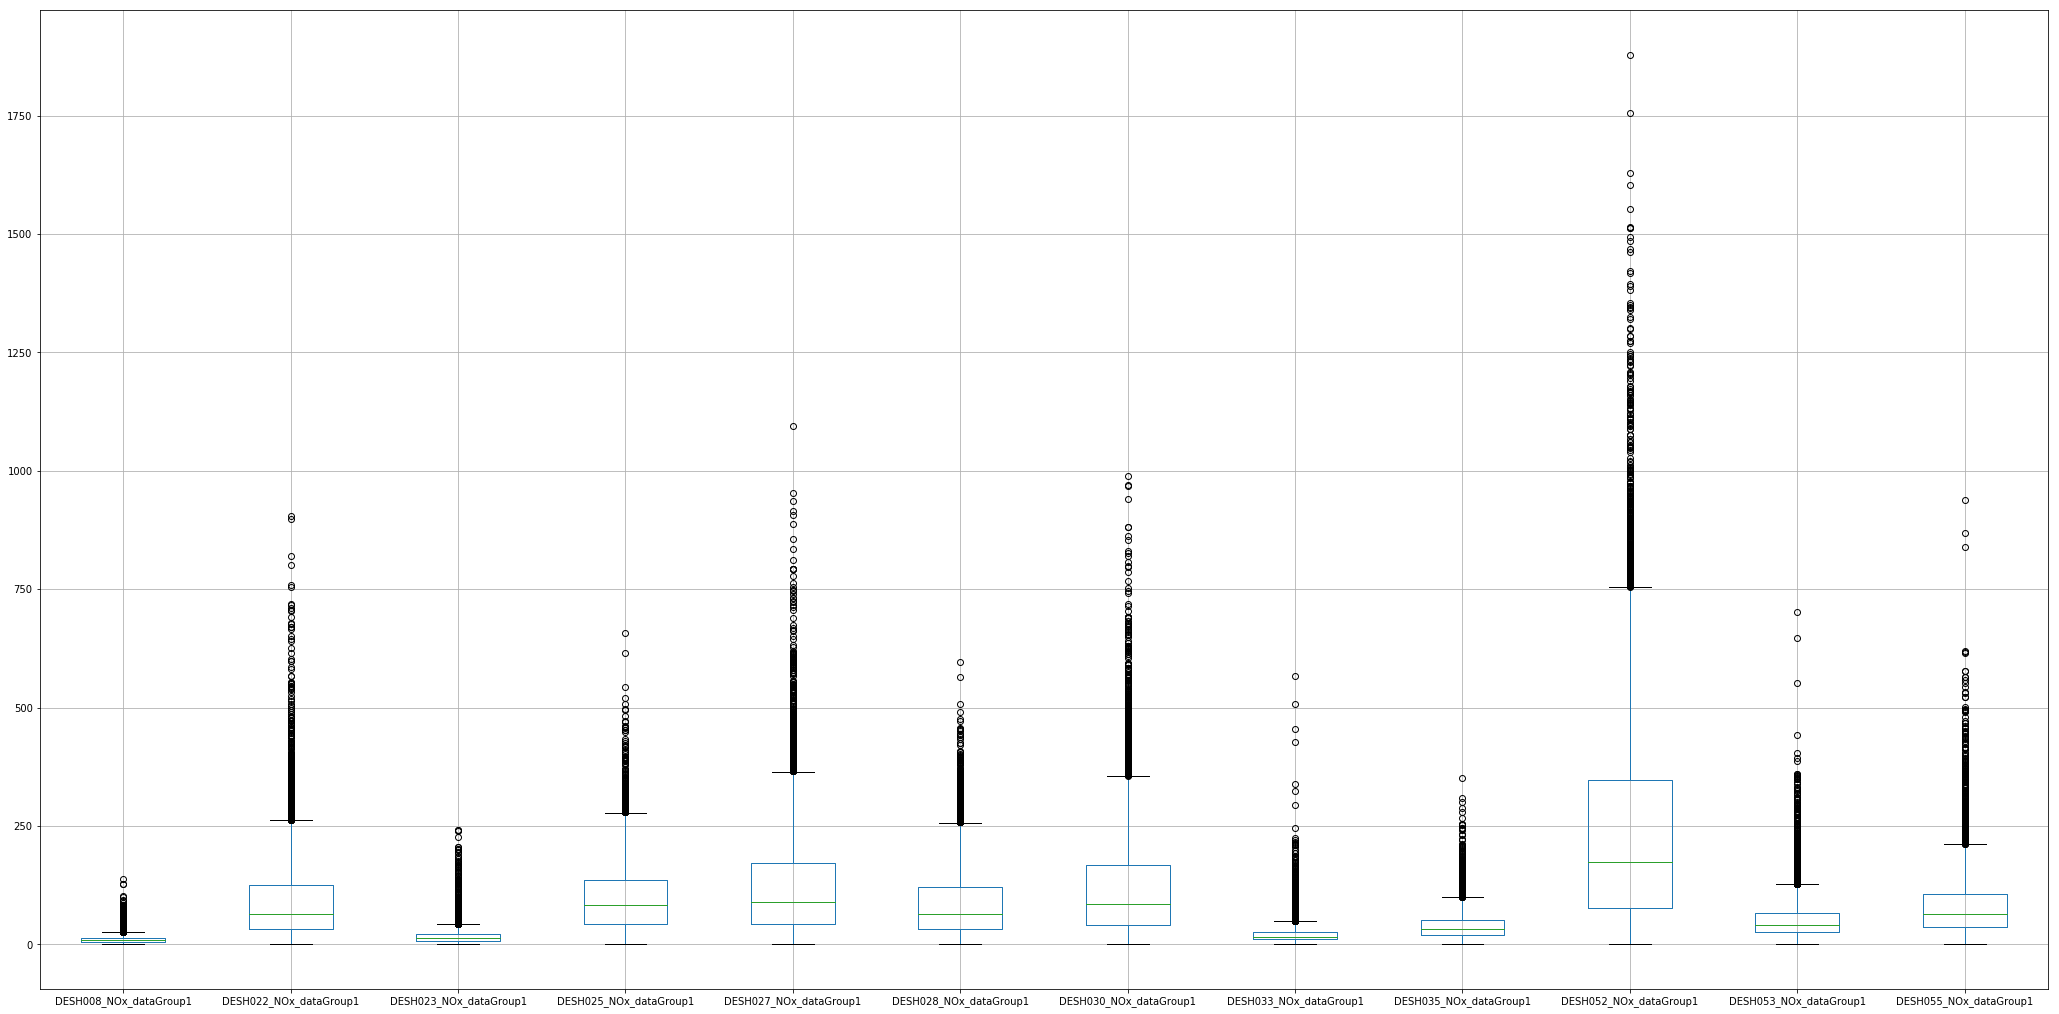

In [23]:
plt.figure(figsize=(36,18))
PollutantConcentrationsState.boxplot()

On the figure above one can see that different sensors demonstrate significantly different statistics, so the data variativity should be enough to be used in the project. Also a quick check of the sanity of the whole pollutant dataset could be done by plotting all the air pollution data set files the way shown above, the data set is not too big and can be processed directly: 

Number of files for hourly averaged pollutant data:  51


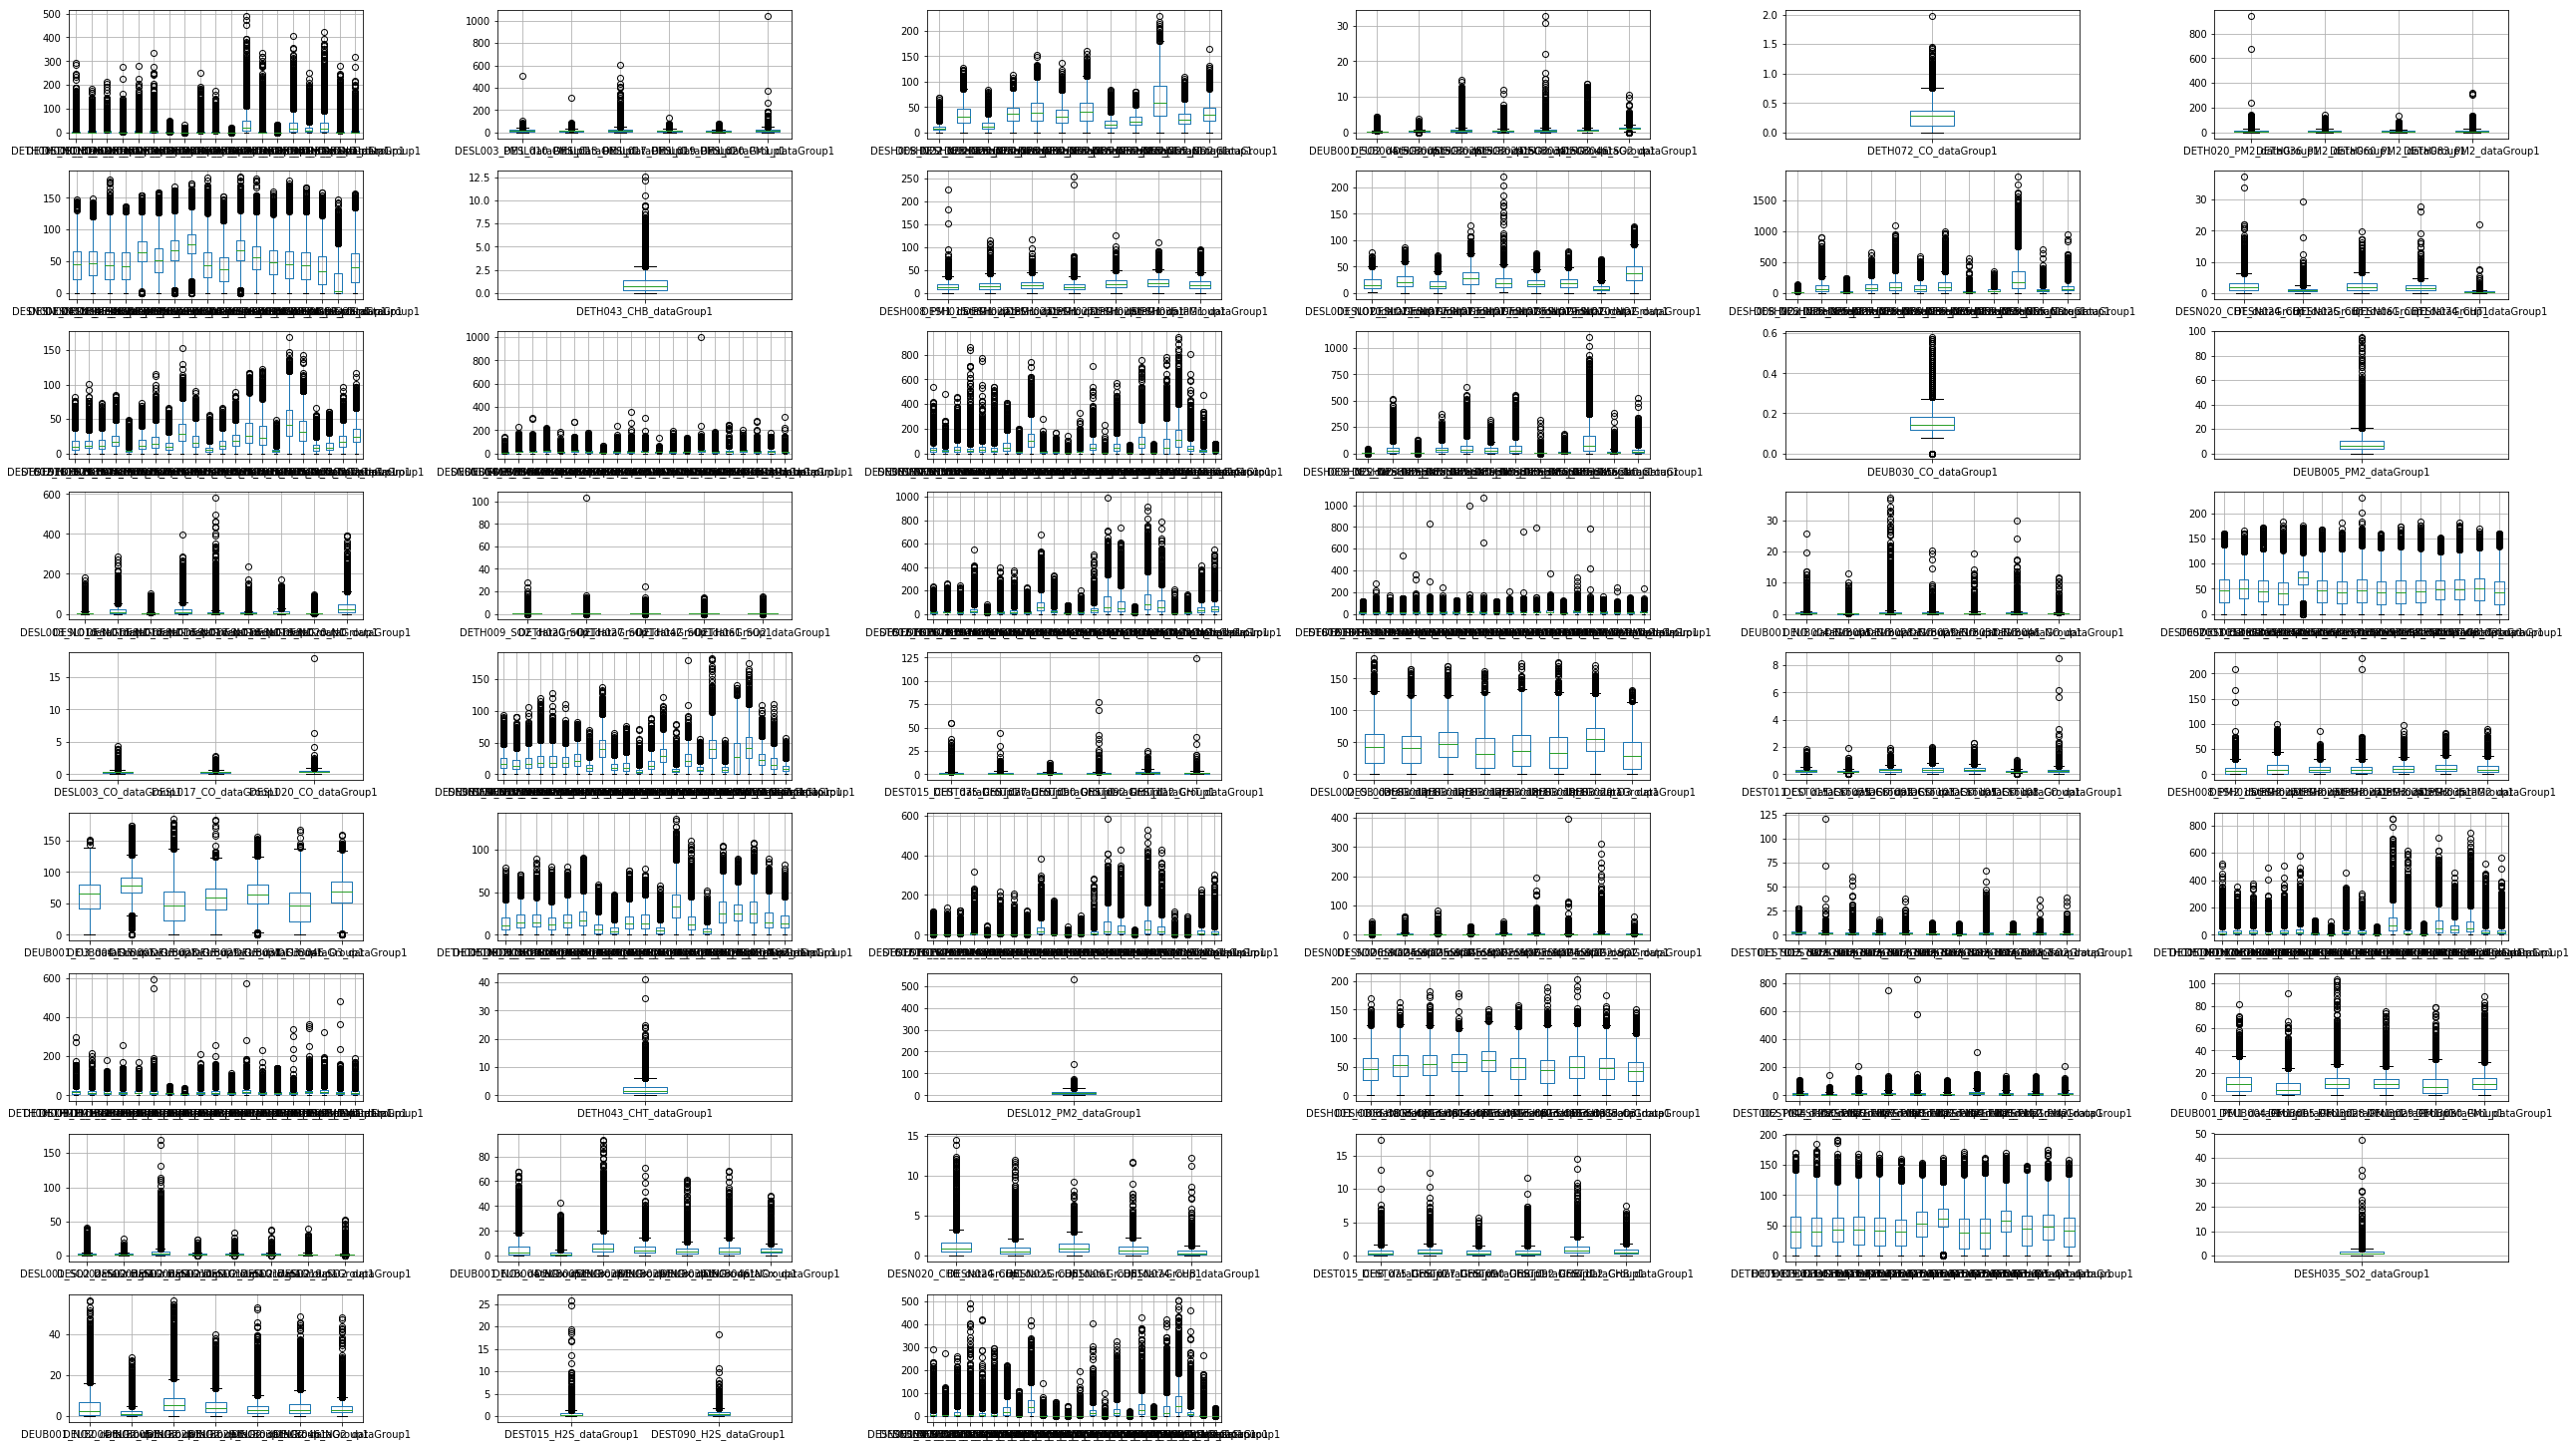

In [24]:
#!ls Capstone.rawData/AQD_DE_E1a_2016/*hour*
# get list of file names for hourly averaged pollutant data
FilesHour=[]
for file in os.listdir('Capstone.rawData/AQD_DE_E1a_2016/'):
    if fnmatch.fnmatch(file, '*hour*'):
        FilesHour.append(file)
print("Number of files for hourly averaged pollutant data: ", len(FilesHour))

#FilesHour=FilesHour[0:12]        

fig = plt.figure(figsize=(36,58))
NfigRows=26
NfigCols=6


for file in FilesHour:
    XMLfilename = 'Capstone.rawData/AQD_DE_E1a_2016/'+file
    AllTagsOfFile = GetAllTags(XMLfilename)
    valuesOfFile = [s for s in AllTagsOfFile if 'values' in s][0]
    Etree = ET.parse(XMLfilename)
    Eroot = Etree.getroot()

    PollutantConcentrationsFile=[]
    for valuei in Eroot.iter(valuesOfFile):
        PollutantConcentrationsFile.append(pd.read_csv(StringIO((valuei.text).replace("@@","\n")), 
                                                       sep=",", header=None)) 
    PollutantConcentrationsAll=pd.concat([PollutantConcentrationsFile[s][4] for s 
                      in range(0,len(PollutantConcentrationsFile))], axis=1)
    PollutantConcentrationsAll.columns = SelectAllXMLsensorID(XMLfilename, AllTagsOfFile)
    PollutantConcentrationsAll=PollutantConcentrationsAll.clip(lower=0)
    
    ax = fig.add_subplot(NfigRows,NfigCols,(FilesHour.index(file)+1))
    ax = (PollutantConcentrationsAll.boxplot(return_type='both'))
    
plt.tight_layout()
plt.show()

### 1.2.8 Exploring sensor position data
Let's examine the xml file with sensor position data. The **sensor IDs** are encoded by *text* of **natlStationCode** and **EUStationCode** tags, and the name of municipality is in *text* of **municipality** tag. More detailed location information, like coordinates (**pos**) and elevation (**altitude**) is available, however it is irrelevant for the present study:

In [25]:
# print out tags from the Metadata XML file
MetadataXMLfile = "Capstone.rawData/DE_D_allInOne_metaMeasurements_2016.xml"
print(*GetAllTags(MetadataXMLfile)[0:25], sep="\n")

{http://www.opengis.net/gml/3.2}FeatureCollection
{http://www.opengis.net/gml/3.2}featureMember
{http://dd.eionet.europa.eu/schemaset/id2011850eu-1.0}AQD_Station
{http://inspire.ec.europa.eu/schemas/ef/3.0}inspireId
{http://inspire.ec.europa.eu/schemas/base/3.3}Identifier
{http://inspire.ec.europa.eu/schemas/base/3.3}localId
{http://inspire.ec.europa.eu/schemas/base/3.3}namespace
{http://inspire.ec.europa.eu/schemas/base/3.3}versionId
{http://inspire.ec.europa.eu/schemas/ef/3.0}name
{http://inspire.ec.europa.eu/schemas/ef/3.0}mediaMonitored
{http://inspire.ec.europa.eu/schemas/ef/3.0}geometry
{http://www.opengis.net/gml/3.2}Point
{http://www.opengis.net/gml/3.2}pos
{http://inspire.ec.europa.eu/schemas/ef/3.0}measurementRegime
{http://inspire.ec.europa.eu/schemas/ef/3.0}mobile
{http://inspire.ec.europa.eu/schemas/ef/3.0}operationalActivityPeriod
{http://inspire.ec.europa.eu/schemas/ef/3.0}OperationalActivityPeriod
{http://inspire.ec.europa.eu/schemas/ef/3.0}activityTime
{http://www.open

### 1.2.9 Exploring prevalence of bronchial asthma data
The dataset can be downloaded at https://www.versorgungsatlas.de/fileadmin/excel/data_id_92_kreis11_1_j_1451606400.xlsx in xlsx format:

xls sheet names:  ['Hintergrundinformationen', 'Daten']
      Region  Regions-ID  KV             Kreistyp  Wert  Bundeswert
0   Eisenach       16056  TH    Ländliches Umland   8.9         5.7
1  Sonneberg       16072  TH      Ländlicher Raum   8.7         5.7
2  Ammerland        3451  NI  Verdichtetes Umland   8.5         5.7
Length of the dataset:  402


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1443bb150>]],
      dtype=object)

<Figure size 432x288 with 0 Axes>

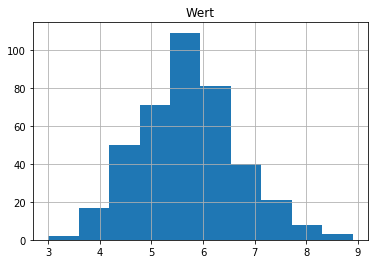

In [26]:
!mkdir Capstone.rawData/Asthma_2016
urllib.request.urlretrieve("https://www.versorgungsatlas.de/fileadmin/excel/data_id_92_kreis11_1_j_1451606400.xlsx", "Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")

xlsx_file = pd.ExcelFile("Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfAsthma = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfAsthma.head(3))
print("Length of the dataset: ",len(dfAsthma))
plt.figure()
dfAsthma.hist(column='Wert')

One can see, that the dataset is of length 402, and it contains name and ID of county (**Region**,**Regions-ID**), state ID (**KV**), type of county (**Kreistyp**), normalized value (% of population) of bronchial asthma prevalence (**Wert**), and the prevalence average (**Bundeswert**). The histogram of the normalized value of bronchial asthma prevalence is shown above. The data has enough variability to be used in the study.

It also looks like, that the disease prevalence dataset has been averaged w.r.t. short (5-digit) county id, that can be same for different counties. The example is shown below; please note, that all locations are located in South Harz mountains:

In [31]:
dfAsthma.loc[dfAsthma['Regions-ID']==15087]

,Region,Regions-ID,KV,Kreistyp,Wert,Bundeswert
310,Mansfeld-Südharz,15087,ST,Ländlicher Raum,5.0,5.7


In [32]:
dfCT.loc[dfCT['CountyID']==15087]

,CountyID,town,county
15081,15087,Mansfeld-Südharz,Sangerhausen
15082,15087,Allstedt,Sangerhausen
15083,15087,Arnstein,Sangerhausen
15084,15087,Eisleben,Sangerhausen
15085,15087,Gerbstedt,Sangerhausen
15086,15087,Hettstedt,Sangerhausen
15087,15087,Mansfeld,Sangerhausen
15088,15087,Sangerhausen,Sangerhausen
15089,15087,Seegebiet Mansfelder Land,Sangerhausen
15090,15087,Südharz,Sangerhausen


## 2 ETL and Data cleansing
## 2.1 Pollutant concentration measurements data
Now the *xml* files with pollutant concentration time series for the given year will be parsed and hourly averaged values of pollutant concentrations will be stored in the **dfAllHour** Pandas DataFrame of the **wide** format (one line contains all measurements for one hour of the year). During the load procedure **consistensy** of **files** and **column** names will be checked:

In [33]:
# directory with downloaded xml files
AirE1aDir='Capstone.rawData/AQD_DE_E1a_2016/'

#!ls Capstone.rawData/AQD_DE_E1a_2016/*hour*
# list for input filenames for hourly averaged pollutant concentration data
FilesHour=[]

for file in os.listdir(AirE1aDir):
    if fnmatch.fnmatch(file, '*hour*'):
        FilesHour.append(file)
print("Number of files in the dataset: ", len(FilesHour))

# shortening the process for debugging purposes
##FilesHour=FilesHour[0:3]        

#NumHoursInYear=8760 # 8760 hours in the year
NumHoursInYear=8784 # 8784 hours in the leap year 2016

dfAllHour=pd.DataFrame(index=range(0,NumHoursInYear))  

# add First column with Observation Times:
dfListTmp=[]  # Temporary list for DataFrames

XMLfilename=AirE1aDir+FilesHour[0]
AllTagsOfFile = GetAllTags(XMLfilename)
valuesOfFile = [s for s in AllTagsOfFile if 'values' in s][0]

for valuei in Eroot.iter(valuesOfFile):
    dfListTmp.append(pd.read_csv(StringIO((valuei.text).replace("@@","\n")), sep=",", header=None))
dfAllHour=pd.concat([dfAllHour, dfListTmp[0][[0]]], axis=1)
dfAllHour.columns=['observation_period']

# get all tags in xml file; Note, that the actual data is kept as a TEXT of *values* tags 
for file in FilesHour:
    XMLfilename = AirE1aDir+file
    AllTagsOfFile = GetAllTags(XMLfilename)
    valuesOfFile = [s for s in AllTagsOfFile if 'values' in s][0]
    Etree = ET.parse(XMLfilename)
    Eroot = Etree.getroot()
   
    ColNamesExp=SelectAllXMLsensorID(XMLfilename, AllTagsOfFile)

    # Compare column names with file names, they should encode same country, state and pollutant:
    for ColName in ColNamesExp:
        if ((ColName[0:2]!=file[0:2]) or (ColName[2:4]!=file[3:5]) or (ColName[8:11]!=file[11:14])):
            print("Inconsistency in file and column names: ", file, ColName)
            exit()
      
    dfListTmp=[] # Temporary list for DataFrames
    # reading actual pollutant data fiom the text field:    
    for valuei in Eroot.iter(valuesOfFile):
        dfListTmp.append(pd.read_csv(StringIO((valuei.text).replace("@@","\n")), sep=",", header=None))

    # checking, that measurment timestamps are identical in the files read       
    for s in range(0,len(dfListTmp)):
        if not (dfAllHour['observation_period']).equals(dfListTmp[s][0]):
            print("Inconsistency of observation times in the following files: ", file, FilesHour[0])
            exit()

# select column 4 - pollutant concentration:
    dfListTmp=pd.concat([dfListTmp[s][4] for s in range(0,len(dfListTmp))], axis=1)
    dfListTmp.columns=ColNamesExp
   
    dfAllHour=pd.concat([dfAllHour, dfListTmp], axis=1)

Number of files in the dataset:  51


Now let's check the dataset size and print a summary:

In [34]:
print("Memory usage: ", (dfAllHour.memory_usage(index=True).sum()/1048576.0), " MB")
dfAllHour.describe()

Memory usage:  35.25080871582031  MB


,DETH005_NO_dataGroup1,DETH009_NO_dataGroup1,DETH011_NO_dataGroup1,DETH013_NO_dataGroup1,DETH018_NO_dataGroup1,DETH020_NO_dataGroup1,DETH026_NO_dataGroup1,DETH027_NO_dataGroup1,DETH036_NO_dataGroup1,DETH041_NO_dataGroup1,...,DESN074_NO_dataGroup1,DESN075_NO_dataGroup1,DESN076_NO_dataGroup1,DESN077_NO_dataGroup1,DESN079_NO_dataGroup1,DESN083_NO_dataGroup1,DESN084_NO_dataGroup1,DESN091_NO_dataGroup1,DESN092_NO_dataGroup1,DESN093_NO_dataGroup1
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,...,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,5.033075,3.717048,3.377787,1.446459,2.254299,-0.592972,-7.134699,-2.384486,-1.005887,3.510440,...,-5.345557,20.499748,-5.950502,20.579246,-15.021168,-218.472799,48.556942,7.896844,-6.046399,-3.104708
std,60.990075,57.377127,55.774444,60.792674,76.098295,99.820136,99.874256,62.140006,89.578400,57.380846,...,81.038834,83.498958,84.413605,136.285352,127.499974,453.085040,129.520082,97.578063,104.552313,69.893914
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,1.247400,1.247400,1.247400,1.247400,1.247400,1.247400,1.247400,1.247400,1.247400,1.247400,...,1.000000,5.584500,1.000000,10.058250,1.000000,-999.000000,16.104000,2.895000,1.000000,1.000000
50%,1.247400,1.247400,2.242464,1.247400,1.247400,3.154191,1.247400,1.247400,1.247400,1.247400,...,1.000000,13.983000,1.000000,24.586000,1.000000,13.160000,44.038500,7.743000,1.000000,1.000000
75%,5.399888,5.606936,6.962457,2.645226,6.118751,7.931578,2.415841,1.247400,4.539022,3.716732,...,1.000000,32.585000,1.000000,50.687250,1.070000,42.270500,85.149250,19.138000,2.840500,1.484000
max,290.826965,185.427277,214.554688,276.600983,279.068970,335.218201,47.983177,31.397560,250.026367,175.672607,...,98.718000,326.315000,19.833000,429.223000,43.384000,419.619000,505.688000,461.780000,263.946000,35.800000


Now we have **wide** data frame, containing timeseries of all pollutant concentrations for all sensors. The pollutant type and the sensor ID are encoded in column names. The minimal value of pollutant concentrations *-999.0* is equivalent to *NA* and will be imputted, as well as all negative values (the concentration can not be negative). The limit for imputation will be set to 876, i.e. *NA* sequences exceeding 10% of the year will not be imputted. Since the number of heavily corrupted columns is below 2%, they will be dropped in favor to the information quality:

In [35]:
dfAllHour[dfAllHour.loc[:, dfAllHour.columns != 'observation_period'] < 0.0] = np.NaN

# imputting missing hourly data using linear interpolation:
dfAllHour.interpolate(method='linear', inplace=True, axis=0, limit=876, limit_direction='both')

print('The number of corrupted columns with more than 10 percent of missing data is ', 
      len(dfAllHour.isna().sum().to_numpy().nonzero()[0]), ' of ', len(dfAllHour.columns))

# dropping heavily corrupted sensor columns:
dfAllHour = dfAllHour.dropna(axis=1)

# converting the hour number to date/time format:
dfAllHour['observation_period']=pd.to_datetime(dfAllHour['observation_period'])
dfAllHour['observation_period']=dfAllHour['observation_period'].dt.to_period('H')
#dfAllHour['observation_period'][0].end_time
dfAllHour.tail(3)

The number of corrupted columns with more than 10 percent of missing data is  10  of  526


/usr/local/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


,observation_period,DETH005_NO_dataGroup1,DETH009_NO_dataGroup1,DETH011_NO_dataGroup1,DETH013_NO_dataGroup1,DETH018_NO_dataGroup1,DETH020_NO_dataGroup1,DETH026_NO_dataGroup1,DETH027_NO_dataGroup1,DETH036_NO_dataGroup1,...,DESN061_NO_dataGroup1,DESN074_NO_dataGroup1,DESN075_NO_dataGroup1,DESN076_NO_dataGroup1,DESN077_NO_dataGroup1,DESN079_NO_dataGroup1,DESN084_NO_dataGroup1,DESN091_NO_dataGroup1,DESN092_NO_dataGroup1,DESN093_NO_dataGroup1
8781,2016-12-31 21:00,38.769691,10.124773,3.618153,4.990111,15.941586,56.984787,16.600275,1.2474,2.616247,...,31.559,1.0,11.265,1.0,16.378,1.0,38.918,78.859,21.667,1.0
8782,2016-12-31 22:00,45.582802,9.339534,6.825025,3.990988,15.941586,20.359314,13.404686,1.2474,4.762816,...,37.010,1.0,20.432,1.0,26.395,1.0,45.879,31.259,22.553,1.0
8783,2016-12-31 23:00,38.601479,21.304909,5.482666,3.903670,15.941586,14.758301,12.856329,1.2474,6.016054,...,36.374,1.0,23.438,1.0,27.355,1.0,32.706,30.349,24.137,1.0


Writing resulting dataframe to csv file:

In [36]:
#!rm -rf ./Capstone.ETL
#!mkdir ./Capstone.ETL
#dfAllHour.to_csv('Capstone.ETL/Capstone.etl.wideCSV.1.0.gzip', compression='gzip', index=False)
#dfAllHour = pd.read_csv('Capstone.ETL/Capstone.etl.wideCSV.1.0.gzip', compression='gzip')

## 2.2 Sensor location data
Now let's construct **SensorLocation** DataFrame containing the **SensorID** and **SensorTown** columns, based on *EUStationCode* and *municipality* xml entries (see sec. 1.2.8 for details):

In [37]:
MetadataXMLfile = "Capstone.rawData/DE_D_allInOne_metaMeasurements_2016.xml"
AllTagsMetadata = GetAllTags(MetadataXMLfile)

#len(AllTags)
varMUN = [s for s in AllTagsMetadata if 'municipality' in s][0]
varID  = [s for s in AllTagsMetadata if 'EUStationCode' in s][0]
varFeatMem = [s for s in AllTagsMetadata if 'featureMember' in s][0]

IDs=[]
MUNs=[]

Etree = etree.parse(MetadataXMLfile)
Eroot = Etree.getroot()
for varr in Eroot.iter(varFeatMem):
    for child in varr.iter(varMUN):
        MUNs.append(child.text)
        for child2 in varr.iter(varID):
            IDs.append(child2.text)
SensorLocation=pd.DataFrame({'SensorID': IDs, 'SensorTown': MUNs})
SensorLocation.tail(5)

,SensorID,SensorTown
762,DEUB005,Lüder
763,DEUB028,Zingst
764,DEUB029,Suhl
765,DEUB030,Stechlin
766,DEUB044,Garmisch-Partenkirchen


## 2.3 Town-County table
The available **disease statistics** is collected on the **county-averaged base**, not a town-based.
We have to download the town-county data set and add a county column to the **SensorLocation** dataframe:

In [38]:
columns = [(10, 15), (22, 71), (72, 121)]
dfCT = pd.read_fwf("Capstone.rawData/GV100AD3107/GV100AD_310719.ASC", 
                     colspecs=columns, names=['CountyID','town','county'],
                     encoding="iso8859_1")
dfCT=dfCT.fillna(method='ffill')

dfCT['town'] = dfCT['town'].str.split(",").str[0]
dfCT.tail(5)

,CountyID,town,county
16116,16077,Starkenberg,Schmölln/Thür.
16117,16077,Thonhausen,Schmölln/Thür.
16118,16077,Treben,Schmölln/Thür.
16119,16077,Vollmershain,Schmölln/Thür.
16120,16077,Windischleuba,Schmölln/Thür.


The mapping of sensor positions to counties is done by setting the **CountyID** to every **sensorID** in the **SensorLocation** DataFrame:


In [39]:
SensorLocation = (SensorLocation.join(dfCT[['CountyID','town']].set_index('town'),
                                      on='SensorTown')).drop_duplicates(subset=['SensorID'])

Checking the resulting table one can see that 23 of 767 entries have not resolved **CountyID**:

In [40]:
print("Total number of sensors: ", SensorLocation.count())
print("Number of sensors with unresolved CountyID: ", SensorLocation[SensorLocation.isna().any(axis=1)].count())
#print("List of unresolved sensors: ", SensorLocation[SensorLocation.isna().any(axis=1)])
print("Number of duplicates in SensorID column: ", SensorLocation.duplicated(['SensorID']).sum())
#SensorLocation.loc[SensorLocation.duplicated(['SensorID'])==True]

Total number of sensors:  SensorID      767
SensorTown    767
CountyID      744
dtype: int64
Number of sensors with unresolved CountyID:  SensorID      23
SensorTown    23
CountyID       0
dtype: int64
Number of duplicates in SensorID column:  0


At the moment it is easier to drop these 3% of sensor's data. Otherwise this table could be corrected manually, since it has reasonable size and it's contents (sensor lables/county codes) hardly changes in time. 

In [41]:
SensorLocation=SensorLocation.dropna()
SensorLocation=SensorLocation.astype({'CountyID':int})
SensorLocation.head(5)

,SensorID,SensorTown,CountyID
0,DEBB007,Elsterwerda,12062
1,DEBB021,Potsdam,12054
2,DEBB026,Spremberg,12071
3,DEBB029,Schwedt/Oder,12073
4,DEBB032,Eisenhüttenstadt,12067


## 2.4 Prevalence of bronchial asthma
The central data frame of the model will contain list of counties, prevalence of disease(s) in this counties, and the set of air-pollution-based features. The *Prevalence of bronchial asthma* dataset is loaded into dfAsthma DataFrame: 

In [42]:
xlsx_file = pd.ExcelFile("Capstone.rawData/Asthma_2016/data_id_92_kreis11_1_j_1451606400.xlsx")
print("xls sheet names: ",xlsx_file.sheet_names)
dfAsthma = xlsx_file.parse('Daten', header=3, decimal=",") 
print(dfAsthma.head(3))
print("Number of duplicates in Regions-ID column: ", dfAsthma.duplicated(['Regions-ID']).sum())

xls sheet names:  ['Hintergrundinformationen', 'Daten']
      Region  Regions-ID  KV             Kreistyp  Wert  Bundeswert
0   Eisenach       16056  TH    Ländliches Umland   8.9         5.7
1  Sonneberg       16072  TH      Ländlicher Raum   8.7         5.7
2  Ammerland        3451  NI  Verdichtetes Umland   8.5         5.7
Number of duplicates in Regions-ID column:  0


In [43]:
dfAsthma = dfAsthma.drop(['Region', 'KV', 'Kreistyp', 'Bundeswert'], axis=1)
dfAsthma.columns=['CountyID','DiseaseR']
dfAsthma.head(5)

,CountyID,DiseaseR
0,16056,8.9
1,16072,8.7
2,3451,8.5
3,16073,8.3
4,3151,8.2


### 2.5 Constructing "Long" DataFrame
Now we create a "long" DataFrame,
containing three columns (pollutant concentration, pollutant name and the county id) and many rows, one for each hourly-averaged measurement.

First the initial **dfAllHour** DataFrame is converted to the "long"-shaped **dfAllLong**:

In [44]:
dfAllLong = pd.melt(dfAllHour, id_vars=['observation_period'], var_name='SensorPollID', value_name='PollutantConc')
dfAllLong.head(5)

,observation_period,SensorPollID,PollutantConc
0,2016-01-01 00:00,DETH005_NO_dataGroup1,26.649330
1,2016-01-01 01:00,DETH005_NO_dataGroup1,21.401394
2,2016-01-01 02:00,DETH005_NO_dataGroup1,12.645019
3,2016-01-01 03:00,DETH005_NO_dataGroup1,12.470383
4,2016-01-01 04:00,DETH005_NO_dataGroup1,15.683311


In [45]:
dfAllLong.shape

(4523760, 3)

Now the **SensorPollID** column should be decomposed to two columns: one indicating county ID, since the disease rate is available on county-based basis, and the second will be the pollutant type.


First a dictionary for translation of *all* sensor's id's to the county id's is created:

In [46]:
SensorCountyDict = dict(zip(SensorLocation.SensorID, SensorLocation.CountyID))

As it has been found, two stations are missing in the file:

DESH055 Lübeck Fackenburger Allee 

DEUB046 Spiegelau, Landkreis Freyung-Grafenau

The corresponding **CountyID** are obtained from *dfCT* DataFrame and added to dictionary manually:

In [47]:
print('DESH055 CountyID = ', dfCT[dfCT['town']=='Lübeck']['CountyID'].unique()[0])
print('DEUB046 CountyID = ', dfCT[dfCT['town']=='Spiegelau']['CountyID'].unique()[0])
SensorCountyDict.update( {'DESH055' : dfCT[dfCT['town']=='Lübeck']['CountyID'].unique()[0]} )
SensorCountyDict.update( {'DEUB046' : dfCT[dfCT['town']=='Spiegelau']['CountyID'].unique()[0]} )

DESH055 CountyID =  1003
DEUB046 CountyID =  9272


In [48]:
SensorCountyDict['DEUB046']

9272

Than the sensor IDs are extracted from the **SensorPollID** column and stored to the **SensorID** column:

In [49]:
dfAllLong['SensorID'] = dfAllLong.apply(lambda row: re.search('(^.{7})', row['SensorPollID']).group(1), axis=1)
#print("Memory usage: ", (dfAllLong.memory_usage(index=True).sum()/1048576.0), " MB")
dfAllLong.tail(3)

,observation_period,SensorPollID,PollutantConc,SensorID
4523757,2016-12-31 21:00,DESN093_NO_dataGroup1,1.0,DESN093
4523758,2016-12-31 22:00,DESN093_NO_dataGroup1,1.0,DESN093
4523759,2016-12-31 23:00,DESN093_NO_dataGroup1,1.0,DESN093


Now the county IDs are calculated from the **SensorID** column and stored to the **CountyID** column:

In [50]:
dfAllLong['CountyID'] = dfAllLong['SensorID'].map(SensorCountyDict)
dfAllLong.tail(3)

,observation_period,SensorPollID,PollutantConc,SensorID,CountyID
4523757,2016-12-31 21:00,DESN093_NO_dataGroup1,1.0,DESN093,14523
4523758,2016-12-31 22:00,DESN093_NO_dataGroup1,1.0,DESN093,14523
4523759,2016-12-31 23:00,DESN093_NO_dataGroup1,1.0,DESN093,14523


In [51]:
print("Total number of sensors is ", (dfAllLong['CountyID'].count()/NumHoursInYear),", ",
      (dfAllLong['CountyID'].isna().sum()/NumHoursInYear), 
      " of them have unresolved CountyID")
#print("List of sensors with unresolved CountyID: ", dfAllLong[dfAllLong['CountyID'].isna()]['SensorPollID'].unique())

Total number of sensors is  515.0 ,  0.0  of them have unresolved CountyID


In [52]:
# Auxiliary code chunk for checking the fraction of counties available both in Pollutant and Disease data sets:

#PollutantSensorPollIDSet = dfAllLong['SensorPollID'].unique()
#PollutantCountySet = dfAllLong['CountyID'].dropna().astype('int64').unique()
#AsthmaCountySet = dfAsthma['CountyID'].unique()

#len(PollutantSensorPollIDSet)
#len(PollutantCountySet)
#len(AsthmaCountySet)

#len(SensorCountyDict)
#a = [t[:7] for t in PollutantSensorPollIDSet]
#b = np.unique(np.array([SensorCountyDict[t] for t in a]))
#PollutantSensorPollIDSet[:][:7]
#print(len(b))
#[t for t in PollutantSensorPollIDSet if 'DETH036' in t]

print("Number of CountyID with available Pollutant and Disease data: ", len(dfAllLong['CountyID'].unique()))

Number of CountyID with available Pollutant and Disease data:  61


Now the **Pollutant** column is added and the **SensorID** and **SensorPollID** columns are dropped:

In [53]:
dfAllLong['Pollutant'] = dfAllLong.apply(lambda row: re.search('^.{8}(.*)_', row['SensorPollID']).group(1), axis=1)
dfAllLong = dfAllLong.drop(['SensorID','SensorPollID'], axis=1)
# if dfAllLong.dropna() is used in the previous line:
# dfAllLong['CountyID'] = dfAllLong['CountyID'].astype('int64')
dfAllLong.tail()
#print("Memory usage: ", (dfAllLong.memory_usage(index=True).sum()/1048576.0), " MB")
#SensorLocation.loc[SensorLocation['SensorID']=='DESL002']

,observation_period,PollutantConc,CountyID,Pollutant
4523755,2016-12-31 19:00,1.0,14523,NO
4523756,2016-12-31 20:00,1.0,14523,NO
4523757,2016-12-31 21:00,1.0,14523,NO
4523758,2016-12-31 22:00,1.0,14523,NO
4523759,2016-12-31 23:00,1.0,14523,NO


Finally the **DiseaseR** column from the **dfAsthma** DataFrame reflecting the disease rate in the corresponding county is added:

In [54]:
dfAllLong = dfAllLong.merge(dfAsthma[['CountyID','DiseaseR']], left_on='CountyID', right_on='CountyID', how='left')
dfAllLong.tail(3)

,observation_period,PollutantConc,CountyID,Pollutant,DiseaseR
4523757,2016-12-31 21:00,1.0,14523,NO,5.5
4523758,2016-12-31 22:00,1.0,14523,NO,5.5
4523759,2016-12-31 23:00,1.0,14523,NO,5.5


In [55]:
print("Total number of sensors is ", (dfAllLong['DiseaseR'].count()/NumHoursInYear),", ", (dfAllLong['DiseaseR'].isna().sum()/NumHoursInYear), " of them have no DiseaseR information")

Total number of sensors is  515.0 ,  0.0  of them have no DiseaseR information


In [56]:
#dfAllLong.to_csv('Capstone.ETL/Capstone.etl.longCSV.1.0.gzip', compression='gzip', index=False)
#dfAllLong = pd.read_csv('Capstone.ETL/Capstone.etl.longCSV.1.0.gzip', compression='gzip')

## 3 Feature Engineering
## 3.1 Pollutant concentration features
Since the study is focused on the long-term health effects caused by the air quality issues, the natural choice is use of some long-term-averaged quantities. For the present study quantile-based features (e.g. median value) of pollutant concentrations are used. 

The following pollutant concentration features will be generated:

- Average (mean) concentration of every kind of pollutant over the year (average over all sensors within the county)
- 75th and 95th percentiles of every kind of pollutant over the year, that is also proportional to the number of hours when the pollutant concentration was above some certain value

### 3.1.1 Mean pollutant concentration over the year in selected county
Starting from the "long" Pandas DataFrame **dfAllLong** the mean pollutant concentrations over the year in selected county are calculated using the following function:

In [57]:
def MeanByPollutantCountyID(Pollutant, CountyID):
    MeanVal = dfAllLong[(dfAllLong['Pollutant']==Pollutant) &
                         (dfAllLong['CountyID']==CountyID)]['PollutantConc'].mean()
    return(MeanVal)

In [58]:
%%time
ListOfPollutants = ['CO','NO','NO2','NOx','O3','PM1','PM2', 'PM10', 'SO2', 'CHB', 'CH4', 'C8H10', 'CHT', 'CO2']
dfAllPollMeanAsthmaRate = dfAsthma
for Pollutant in ListOfPollutants:
    ColIndex=Pollutant+'mean'
    dfAllPollMeanAsthmaRate[ColIndex] = dfAllPollMeanAsthmaRate['CountyID'].map(lambda x:
                                        MeanByPollutantCountyID(Pollutant, x))                                    

CPU times: user 26min 47s, sys: 47.6 s, total: 27min 35s
Wall time: 29min 23s


In [59]:
dfAllPollMeanAsthmaRate.isna().sum()

CountyID       0
DiseaseR       0
COmean       391
NOmean       347
NO2mean      347
NOxmean      349
O3mean       349
PM1mean      352
PM2mean      383
PM10mean     402
SO2mean      372
CHBmean      391
CH4mean      402
C8H10mean    402
CHTmean      391
CO2mean      402
dtype: int64

From the table above one can see, that only 5 pollutants (*NO, NO2, NOx, O3, PM1*) were measured in about 12% of German counties (total number of counties mentioned in the *bronchial asthma* dataset is 402). Let's take a look, in how many counties all 6 pollutants were measured simultaneously:

In [60]:
FeatureSetMean5AsthmaRate = dfAllPollMeanAsthmaRate[['CountyID','DiseaseR','NOmean',
                                                 'NO2mean','NOxmean','O3mean',
                                                 'PM1mean']].dropna().reset_index(drop=True)
#FeatureSetMean5AsthmaRate.tail(3)
FeatureSetMean5AsthmaRate.describe()

,CountyID,DiseaseR,NOmean,NO2mean,NOxmean,O3mean,PM1mean
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,12808.853659,5.892683,11.080357,17.006610,33.376637,50.300838,15.403850
std,5116.970830,1.083834,12.537475,9.346524,28.226955,8.834913,3.595645
min,1002.000000,4.200000,0.163299,2.155348,2.637490,40.642753,7.460854
25%,14521.000000,5.200000,2.047583,9.932120,12.899541,44.599687,12.520184
50%,15003.000000,5.700000,6.803691,15.297707,25.471797,48.419621,15.508504
75%,16053.000000,6.700000,16.512197,21.987611,43.649763,52.279996,18.206161
max,16077.000000,8.700000,58.916103,41.784301,132.030190,83.072606,21.824518


From the table above one can conclude, that despite only about one eighth of German counties are included into the **FeatureSet5AsthmaRate** dataset, all the measured quantities have good variability. In order to illustrate it, the histograms are plotted:

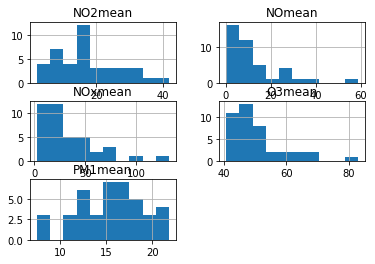

In [61]:
FeatureSetMean5AsthmaRate.hist(column=['NOmean','NO2mean','NOxmean','O3mean','PM1mean']);

We can also maximize number of counties in the dataset, removing 2 of 5 pollutants. It is found, that for the current dataset it will lead to increase of observations up to 49:

In [62]:
FeatureSetMean3AsthmaRate = dfAllPollMeanAsthmaRate[['CountyID','DiseaseR','NOmean','NO2mean','PM1mean']].dropna().reset_index(drop=True)
FeatureSetMean3AsthmaRate.columns=['CountyID','DiseaseR','NOmean','NO2mean','PM1mean']
FeatureSetMean3AsthmaRate.describe()

,CountyID,DiseaseR,NOmean,NO2mean,PM1mean
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,12407.571429,5.875510,12.508166,18.274223,15.935149
std,5314.798471,1.097066,12.661156,9.297198,3.599833
min,1001.000000,4.200000,0.163299,2.155348,7.460854
25%,12065.000000,5.000000,2.246570,11.887994,13.327512
50%,15001.000000,5.700000,7.809633,16.773922,16.167680
75%,16052.000000,6.700000,16.884384,23.695453,18.558537
max,16077.000000,8.700000,58.916103,41.784301,22.832089


Writing mean pollutant concentration feature to csv files:

In [63]:
#!rm -rf Capstone.FeatureEng
#!mkdir Capstone.FeatureEng
#FeatureSetMean5AsthmaRate.to_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSetMean5AsthmaRate.1.0.csv', index=False)
#FeatureSetMean3AsthmaRate.to_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSetMean3AsthmaRate.1.0.csv', index=False)
#FeatureSetMean5AsthmaRate = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSetMean5AsthmaRate.1.0.csv')
#FeatureSetMean3AsthmaRate = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSetMean3AsthmaRate.1.0.csv')

### 3.1.2 Quantile of pollutant concentration over the year in selected county
Starting from the "long" Pandas DataFrame **dfAllLong** the quantiles of pollutant concentrations over the year in selected county could be calculated using the following function:

In [64]:
def PercentileByPollutantCountyID(Percentile, Pollutant, CountyID):
    PercVal = dfAllLong[(dfAllLong['Pollutant']==Pollutant) &
                         (dfAllLong['CountyID']==CountyID)]['PollutantConc'].quantile(Percentile/100.0)
    return(PercVal)

However the straightforward fetch over the whole **dfAllLong** "long" DataFrame is not very efficient,
the quantile features will be calculated using the "wide" Pandas DataFrame **dfAllHour**. Parsing the column names and dropping non-relevant columns of the DataFrame we can avoid unnecessary effort of the filtering process. 

In [65]:
# Function for Cropping of initial dffAll dataset to columns reflecting measurements 
# of pollutants from ListOfPollutants at counties from ListOfCountyIDs:
def CropPollutantsIDsTS(ListOfPollutants, ListOfCountyIDs):
    CountyStationSet=[]
    dfAllCrop=pd.DataFrame(dfAllHour['observation_period'])

    for CountyID in ListOfCountyIDs:
        CountyStationSet.extend(SensorLocation.loc[SensorLocation['CountyID']==CountyID]['SensorID'].tolist())
    for Pollutant in ListOfPollutants:
        PollutantMasc='^.{8}' + Pollutant + '_' 
        dfAllCrop=dfAllCrop.join(dfAllHour[[col for col in dfAllHour.columns 
                                            if re.search('(^.{7})',col).group(1) 
                                            in CountyStationSet]].filter(regex=PollutantMasc,axis=1))
    return(dfAllCrop)

# Function for calculating Nth percentiles for pollutants in ListOfPollutants at counties in ListOfCountyIDs:
def ReturnNthPercentilePollutantsIDsTS(Percentile, ListOfPollutants, ListOfCountyIDs):
    CountyStationSet=[]
    NthPercentile=pd.DataFrame()

    for CountyID in ListOfCountyIDs:
        CountyStationSet.extend(SensorLocation.loc[SensorLocation['CountyID']==CountyID]['SensorID'].tolist())
    for Pollutant in ListOfPollutants:
        PollutantMasc='^.{8}' + Pollutant + '_'
        NthPercentile[Pollutant] = [(dfAllHour[[col for col in dfAllHour.columns 
                                                if re.search('(^.{7})',col).group(1) 
                                                in CountyStationSet]].filter(regex=PollutantMasc,axis=1)).stack()
                                                                     .reset_index(drop=True)
                                                                     .quantile(Percentile/100.0)]
    return(NthPercentile)

# Function for calculating Feature matrix, containing values on Nth percentile 
# for each pollutant from ListOfPollutants
# in counties of interest (in ListOfCountyIDs):
def FeatureMatrixNthPercentile(Percentile, ListOfPollutants, ListOfCountyIDs):
    dfAllCrop=CropPollutantsIDsTS(ListOfPollutants, ListOfCountyIDs)

    FeatureMatrix=pd.DataFrame({'CountyID': dfAsthma.loc[dfAsthma['CountyID']
                                                          .isin(ListOfCountyIDs)]['CountyID'],
                                'DiseaseR': dfAsthma.loc[dfAsthma['CountyID']
                                                          .isin(ListOfCountyIDs)]['DiseaseR']}).reset_index(drop=True)
    for Pollutant in ListOfPollutants:
        PollutantNthPercentile=[]
        PollutantMasc='^.{8}' + Pollutant + '_'
        for CountyID in ListOfCountyIDs:
            CountyStationSet=[]
            CountyStationSet.extend(SensorLocation.loc[SensorLocation['CountyID']==CountyID]['SensorID'].tolist())

            dfPollutantCounty = dfAllCrop[[col for col in dfAllCrop.columns 
                                             if re.search('(^.{7})',col).group(1) 
                                             in CountyStationSet]].filter(regex=PollutantMasc,axis=1)
            NumPollutantStationsAtCounty = dfPollutantCounty.shape[1]
            PollutantNthPercentile.append(dfPollutantCounty.stack().reset_index(drop=True).quantile(Percentile/100.0))
        FeatureMatrix = FeatureMatrix.reset_index(drop=True).join(pd.DataFrame({Pollutant : PollutantNthPercentile}))        
    return(FeatureMatrix)

The same way as it was done for the pollutant mean as a feature, the quantile-based features with two types of pollutant lists (the same as *FeatureSet5* and *FeatureSet3*) and three percentile values (50 and 75) will be created:

In [66]:
%%time

ListOfCountyIDsPoll5 = FeatureSetMean5AsthmaRate['CountyID']
FeatureSet50Perc5AsthmaRate = FeatureMatrixNthPercentile(50, ['NO','NO2','NOx','O3','PM1'], ListOfCountyIDsPoll5)
FeatureSet75Perc5AsthmaRate = FeatureMatrixNthPercentile(75, ['NO','NO2','NOx','O3','PM1'], ListOfCountyIDsPoll5)

ListOfCountyIDsPoll3 = FeatureSetMean3AsthmaRate['CountyID']
FeatureSet50Perc3AsthmaRate = FeatureMatrixNthPercentile(50, ['NO','NO2','PM1'], ListOfCountyIDsPoll3)
FeatureSet75Perc3AsthmaRate = FeatureMatrixNthPercentile(75, ['NO','NO2','PM1'], ListOfCountyIDsPoll3)

CPU times: user 5.3 s, sys: 573 ms, total: 5.88 s
Wall time: 8.43 s


In [67]:
FeatureSet50Perc5AsthmaRate.tail(10)

,CountyID,DiseaseR,NO,NO2,NOx,O3,PM1
31,14522,5.0,1.000000,10.166000,12.905500,67.500000,10.193500
32,14625,5.0,2.747000,13.837000,18.652500,46.290000,15.254000
33,14521,4.8,5.888000,16.437000,25.865500,64.527000,7.724000
34,14626,4.8,1.523000,11.552000,14.846000,46.031000,15.734500
35,15085,4.7,0.501360,6.307958,7.109468,56.310125,10.889750
36,8315,4.6,0.020000,1.220000,1.361411,80.470000,5.090000
37,15091,4.6,3.344782,15.852075,21.797147,46.560250,16.060575
38,15081,4.4,0.290863,5.438060,6.023081,44.041775,10.747824
39,13073,4.3,0.115357,4.045286,4.450000,60.895000,9.740000
40,16064,4.2,5.531767,18.790456,26.826207,41.581406,15.507284


Writing the feature sets to csv files:

In [27]:
#FeatureSet50Perc3AsthmaRate.to_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSet50Perc3AsthmaRate.1.0.csv', index=False)
#FeatureSet75Perc3AsthmaRate.to_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSet75Perc3AsthmaRate.1.0.csv', index=False)
#FeatureSet50Perc5AsthmaRate.to_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSet50Perc5AsthmaRate.1.0.csv', index=False)
#FeatureSet75Perc5AsthmaRate.to_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSet75Perc5AsthmaRate.1.0.csv', index=False)

#FeatureSet50Perc3AsthmaRate = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSet50Perc3AsthmaRate.1.0.csv')
#FeatureSet75Perc3AsthmaRate = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSet75Perc3AsthmaRate.1.0.csv')
#FeatureSet50Perc5AsthmaRate = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSet50Perc5AsthmaRate.1.0.csv')
#FeatureSet75Perc5AsthmaRate = pd.read_csv('Capstone.FeatureEng/Capstone.feature_eng.FeatureSet75Perc5AsthmaRate.1.0.csv')

## 3.2 Health indicator feature creation
Since the task is to build a classification model, the continuous **DiseaseR** column should be transformed to discrete label, indicating high-risk and low-risk counties. A natural choice of such label would be a presence of the county in Nth percentile of the disease prevalence. The feature sets, containing 50th, 75th and 95th percentiles of bronchial asthma prevalence as a label will be created:

In [28]:
def AddDiseasePercColumn(FeatureSetDF, Percentile):
    LabelNPerc = 'DiseasePerc'+str(Percentile)
    DiseasePercentile = (FeatureSetDF['DiseaseR']).quantile(Percentile/100.0)
    FeatureSetDF[LabelNPerc] = ((FeatureSetDF['DiseaseR'])>DiseasePercentile).astype(int)

In [29]:
FeatureSet50Perc3Asthma = FeatureSet50Perc3AsthmaRate.copy(deep=True)
FeatureSet75Perc3Asthma = FeatureSet75Perc3AsthmaRate.copy(deep=True)
FeatureSet50Perc5Asthma = FeatureSet50Perc5AsthmaRate.copy(deep=True)
FeatureSet75Perc5Asthma = FeatureSet75Perc5AsthmaRate.copy(deep=True)

DiseasePercList = [50, 75, 95]

for DiseasePerc in DiseasePercList:
    AddDiseasePercColumn(FeatureSet50Perc3Asthma, DiseasePerc)
    AddDiseasePercColumn(FeatureSet75Perc3Asthma, DiseasePerc)
    AddDiseasePercColumn(FeatureSet50Perc5Asthma, DiseasePerc)
    AddDiseasePercColumn(FeatureSet75Perc5Asthma, DiseasePerc)

In [30]:
FeatureSet50Perc3Asthma.head(5)

,CountyID,DiseaseR,NO,NO2,PM1,DiseasePerc50,DiseasePerc75,DiseasePerc95
0,16072,8.7,1.2474,4.431292,6.428730,1,1,1
1,16073,8.3,1.2474,10.948489,15.363067,1,1,1
2,1001,7.7,22.2185,30.770500,16.240500,1,1,0
3,16062,7.7,1.2474,14.630816,13.519355,1,1,0
4,16054,7.5,1.2474,9.137289,10.434895,1,1,0


## 4 Define the Model
## 4.1 Linear Regression
### 4.1.1 Multivariate regression
Due to the fact, that resulting feature matrices are of quite small size, the Linear Regression can be used for initial analysis of the data set.

In [72]:
FeatureSet = FeatureSet75Perc5AsthmaRate

print(FeatureSet.head(3))

X, y = FeatureSet.drop(['CountyID', 'DiseaseR'], axis=1), FeatureSet['DiseaseR']
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

### Single variable regression
#Xsingle = X[:,0]
#Xsingle = sm.add_constant(Xsingle)
#model_LR1=sm.OLS(y, Xsingle).fit()

#plt.scatter(FeatureSetDensePerc50['DiseaseR'], FeatureSetDensePerc50['NOx'])

#model_LR1=ols("DiseaseR ~ NO + NO2 + PM1", data = FeatureSet).fit()
model_LR1=ols("y ~ X", data = FeatureSet).fit()

print(anova_lm(model_LR1))
print(model_LR1.summary())

   CountyID  DiseaseR        NO        NO2        NOx         O3        PM1
0     16072       8.7  1.247400   8.199851   8.217401  77.968842  10.744470
1     16073       8.3  5.503870  20.120240  27.905221  64.319496  23.862694
2     16062       7.7  6.258574  24.595467  33.737950  63.655087  19.844954
            df     sum_sq   mean_sq         F    PR(>F)
X          5.0   7.854050  1.570810  1.404883  0.246576
Residual  35.0  39.133755  1.118107       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.405
Date:                Thu, 23 Apr 2020   Prob (F-statistic):              0.247
Time:                        11:33:47   Log-Likelihood:                -57.221
No. Observations:                  41   AIC:          

The results shows relatively high p-values and different correlation signs for nitrogen oxides, showing that the linear regression coefficients are unreliable. The same linear regression model can be realized by means of PyTorch:

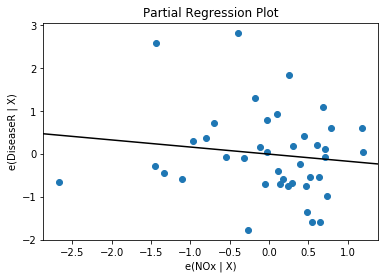

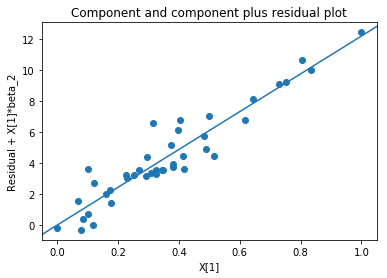

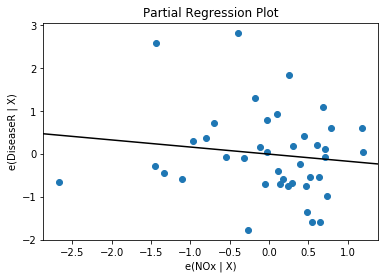

In [73]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_ccpr(model_LR1, 2, ax=ax)
#ax.set_title("Multivariate Regression");

sm.graphics.plot_partregress(endog='DiseaseR', exog_i='NOx', exog_others=['PM1', 'NO', 'NO2', 'O3'],data=FeatureSet, obs_labels=False)
#sm.graphics.plot_partregress(endog='DiseaseR', exog_i='NO', exog_others=['PM1'],data=FeatureSet, obs_labels=False)


### 4.1.2 Single variable regression


   CountyID  DiseaseR        NO        NO2        NOx         O3        PM1
0     16072       8.7  1.247400   8.199851   8.217401  77.968842  10.744470
1     16073       8.3  5.503870  20.120240  27.905221  64.319496  23.862694
2     16062       7.7  6.258574  24.595467  33.737950  63.655087  19.844954


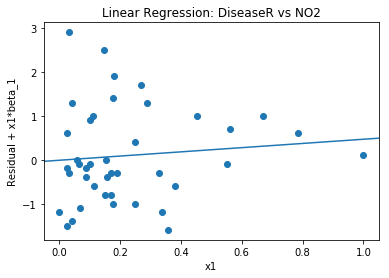

In [74]:
FeatureSet = FeatureSet75Perc5AsthmaRate

print(FeatureSet.head(3))

X, y = FeatureSet.drop(['CountyID', 'DiseaseR'], axis=1), FeatureSet['DiseaseR']
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# Selecting the regression variable:
NumVarRegress=2

Xsingle = X[:,NumVarRegress]
Xsingle = sm.add_constant(Xsingle)
model_LR2=sm.OLS(y, Xsingle).fit()

fig, ax = plt.subplots()
fig = sm.graphics.plot_ccpr(model_LR2, 1, ax=ax)
ax.set_title("Linear Regression: DiseaseR vs NO2");

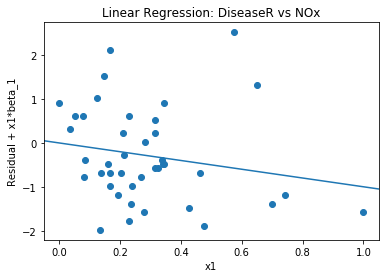

In [75]:
# Selecting the regression variable:
NumVarRegress=3

Xsingle = X[:,NumVarRegress]
Xsingle = sm.add_constant(Xsingle)
model_LR2=sm.OLS(y, Xsingle).fit()

fig, ax = plt.subplots()
fig = sm.graphics.plot_ccpr(model_LR2, 1, ax=ax)
ax.set_title("Linear Regression: DiseaseR vs NOx");

In the case of single variable regression there is the same problem: different correlation signs for different nitrogen oxides, showing that the linear regression coefficients are unreliable.

## 4.2 Support Vector Machine Classifier (SVC)


In [76]:
from sklearn import svm

FeatureSet = FeatureSet75Perc5Asthma

print(FeatureSet.head(3))

classifier = svm.SVC(gamma=0.0001, C=100.)
X, y = FeatureSet.drop(['CountyID', 'DiseaseR', 'DiseasePerc50', 'DiseasePerc75', 'DiseasePerc95'], axis=1), FeatureSet['DiseasePerc75']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

SVC = classifier.fit(X_train, y_train)
print("SVC accuracy is ", accuracy_score(y_test, SVC.predict(X_test)))

   CountyID  DiseaseR        NO        NO2        NOx         O3        PM1  \
0     16072       8.7  1.247400   8.199851   8.217401  77.968842  10.744470   
1     16073       8.3  5.503870  20.120240  27.905221  64.319496  23.862694   
2     16062       7.7  6.258574  24.595467  33.737950  63.655087  19.844954   

   DiseasePerc50  DiseasePerc75  DiseasePerc95  
0              1              1              1  
1              1              1              1  
2              1              1              0  
SVC accuracy is  0.6666666666666666


The SVM always predict zeroes, giving 2/3 accuracy at the current train/test splitting.
This behavior has been tested on all feature sets.
The SVM is inappropriate classifier for the current dataset.

## 4.3 Gradient-Boosted Trees (GBT)

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

FeatureSet = FeatureSet75Perc5Asthma

print(FeatureSet.head(3))

#classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
X, y = FeatureSet.drop(['CountyID', 'DiseaseR', 'DiseasePerc50', 'DiseasePerc75', 'DiseasePerc95'], axis=1), FeatureSet['DiseasePerc75']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#GBT = classifier.fit(X_train, y_train)
#print("GBT accuracy is ", accuracy_score(y_test, GBT.predict(X_test)))

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(classifier.score(X_test, y_test)))

   CountyID  DiseaseR        NO        NO2        NOx         O3        PM1  \
0     16072       8.7  1.247400   8.199851   8.217401  77.968842  10.744470   
1     16073       8.3  5.503870  20.120240  27.905221  64.319496  23.862694   
2     16062       7.7  6.258574  24.595467  33.737950  63.655087  19.844954   

   DiseasePerc50  DiseasePerc75  DiseasePerc95  
0              1              1              1  
1              1              1              1  
2              1              1              0  
Learning rate:  0.05
Accuracy score (training): 0.844
Accuracy score (validation): 0.667
Learning rate:  0.075
Accuracy score (training): 0.875
Accuracy score (validation): 0.667
Learning rate:  0.1
Accuracy score (training): 0.875
Accuracy score (validation): 0.667
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.667
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.556
Learning rate:  0.75
Accuracy score (traini

In [39]:
from sklearn import tree
import pydotplus
from IPython.display import Image

sub_tree_42 = classifier.estimators_[12, 0]

dot_data = tree.export_graphviz(
    sub_tree_42,
    out_file=None, filled=True,
    rounded=True,  
    special_characters=True,
    proportion=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png()) 
#a = graph.create_png()

The GBT always has very low out-of-sample accuracy, independent on the learning rate.
The GBT is inappropriate classifier for the current dataset.

## 4.4 Multilayer perceptron classifier (MLPC)
### 4.4.1 Sklearn

In [78]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

FeatureSet = FeatureSet75Perc5Asthma

print(FeatureSet.head(3))

#classifier = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
X, y = FeatureSet.drop(['CountyID', 'DiseaseR', 'DiseasePerc50', 'DiseasePerc75', 'DiseasePerc95'], axis=1), FeatureSet['DiseasePerc75']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

alpha_list = [1e-6, 1e-5, 1e-4, 1e-3]

for alpha in alpha_list:
    classifier = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=(8, 7), random_state=1)
    classifier.fit(X_train, y_train)

    print("alpha: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(classifier.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(classifier.score(X_test, y_test)))

   CountyID  DiseaseR        NO        NO2        NOx         O3        PM1  \
0     16072       8.7  1.247400   8.199851   8.217401  77.968842  10.744470   
1     16073       8.3  5.503870  20.120240  27.905221  64.319496  23.862694   
2     16062       7.7  6.258574  24.595467  33.737950  63.655087  19.844954   

   DiseasePerc50  DiseasePerc75  DiseasePerc95  
0              1              1              1  
1              1              1              1  
2              1              1              0  
alpha:  1
Accuracy score (training): 0.938
Accuracy score (validation): 0.667
alpha:  1
Accuracy score (training): 0.906
Accuracy score (validation): 0.556
alpha:  1
Accuracy score (training): 0.938
Accuracy score (validation): 0.667
alpha:  1
Accuracy score (training): 0.906
Accuracy score (validation): 0.667


### 4.4.2 TensorFlow
Now the Multilayer Perceptron classifier model will be built in the TensorFlow framework.
The dataset to be used is *FeatureSet75Perc5Asthma*, i.e. values of 75th percentile of the pollutant concentration as features, and the *DiseasePerc75* column as a label. The *DiseasePerc75* column contains 0 if the county is not in 75th percentile of bronchial asthma prevalence in all counties, and 1 otherwise.

Initial dataset is splitted into train(80%) and test (20%) sets. Complete list of pollutant concentrations percentile values available in the dataset is used.

In [79]:
from sklearn.model_selection import train_test_split
from tensorflow.python.lib.io import file_io


FeatureSet = FeatureSet75Perc5Asthma
FeatureSet = FeatureSet.drop(['CountyID', 'DiseaseR', 'DiseasePerc50', 'DiseasePerc95'], axis=1)

print(FeatureSet.head(3))
FeatureSet.describe()

train_set_df, test_set_df = train_test_split(FeatureSet, test_size=0.2)
train_set_df.to_csv('train_set.csv', header=False, index=False, encoding='utf-8')
test_set_df.to_csv('test_set.csv', header=False, index=False, encoding='utf-8')

ListOfPollutants = ['NO','NO2','NOx','O3','PM1']

train_mean = collections.defaultdict(list)
train_std = collections.defaultdict(list)

for Pollutant in ListOfPollutants:
    train_mean[Pollutant].append(train_set_df[Pollutant].mean())
    train_std[Pollutant].append(train_set_df[Pollutant].std())

         NO        NO2        NOx         O3        PM1  DiseasePerc75
0  1.247400   8.199851   8.217401  77.968842  10.744470              1
1  5.503870  20.120240  27.905221  64.319496  23.862694              1
2  6.258574  24.595467  33.737950  63.655087  19.844954              1


In [80]:
%%bash
wc -l *_set.csv

       9 test_set.csv
      32 train_set.csv
      41 total


In [81]:
!head *_set.csv

==> test_set.csv <==
2.15569875,18.839862500000002,22.35510075,66.732375,21.143587500000002,0
1.5,12.1485,13.935000000000002,70.12225000000001,18.773083333333332,0
6.64525,21.879,31.786,65.206,22.585,0
74.3585,58.306999999999995,174.04250000000002,65.855,27.6265,0
0.5,9.29,10.23,70.2625,15.07,1
1.24740005,7.226661322499999,7.2364145525,69.272108075,14.534800050000001,0
6.0089999999999995,19.622,28.90625,83.48774999999999,15.809249999999999,0
7.000315667500001,23.4197101625,33.142453195,62.92048645,19.2161254875,1
4.659257650000001,21.7969541525,29.024507049999997,61.6111783975,19.127059935,0

==> train_set.csv <==
2.0904366999999997,18.9680318825,21.807508742499998,66.437950135,19.56988623,1
3.7748992475,23.71736622,29.9073643675,61.448883057500005,20.797291755,0
44.485857142857135,47.39575,117.2660673076923,61.375,26.08,1
1.24740005,8.20019293,8.20019293,74.21460914250001,14.362365482500001,0
7.78775,20.616,33.007749999999994,66.682,23.674249999999997,0
10.97225,29.37525,45.5755,68.20

The features are normalized using range of values in the train dataset:

In [83]:
def zscore(col):
    mean = train_mean[col]
    std = train_std[col]
    return (col - mean)/std

ListOfPollutants = ['NO','NO2','NOx','O3','PM1']

feature_columns = []

for Pollutant in ListOfPollutants:
#   PollutantBoundaries = list(np.arange(FeatureSet[Pollutant].min(), FeatureSet[Pollutant].max()))
    PollutantColumn = tf.feature_column.numeric_column(key=Pollutant, normalizer_fn=zscore)
#   PollutantBucketized = tf.feature_column.bucketized_column(source_column = PollutantColumn, boundaries = PollutantBoundaries)
    feature_columns.append(PollutantColumn)


The *read_dataset* function is used for reading, batching and shuffling input data:

In [85]:
record_defaults = [[1.0], [1.0],[1.0],[1.0],[1.0],[1]]
column_keys = ["NO", "NO2", "NOx", "O3", "PM1", "DiseasePerc75"]
label_key = "DiseasePerc75"
def read_dataset(filename, mode, batch_size = 32):
    def _input_fn():
        def decode_csv(value_column):
            columns = tf.io.decode_csv(value_column,record_defaults=record_defaults)
            features = dict(zip(column_keys, columns))          
            label = features.pop(label_key)         
            return features, label

        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(file_list).map(decode_csv)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
            dataset = dataset.shuffle(buffer_size = 2 * batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs).batch(batch_size)
        iterator = tf.compat.v1.data.make_one_shot_iterator(dataset).get_next()

        return tf.stack(list(iterator[0].values()), axis=1), iterator[1]    
#       return tf.compat.v1.data.make_one_shot_iterator(dataset).get_next()
##      return dataset.make_one_shot_iterator().get_next()
    return _input_fn

The network will be created using number of layers and neurons defined in model parameters:  

In [86]:
def model_fn(features, labels, mode, params):
    net = features
    for units in params['hidden_units']:
        net = tf.compat.v1.layers.dense(net, units=units, activation=tf.nn.relu)
   # Compute logits (1 per class).
    logits = tf.compat.v1.layers.dense(net, 1, activation=None) 
    
    predicted_classes = tf.argmax(logits, 1)
    predicted_class_names = tf.gather(tf.constant(['Low risk', 'High risk']), predicted_classes)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
        'class_ids': predicted_classes[:, tf.newaxis],
        'class_names' : predicted_class_names[:, tf.newaxis],
        'probabilities': tf.nn.softmax(logits),
        'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Compute loss.
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = bce(labels, logits)
    
    # Compute evaluation metrics.
    accuracy = tf.compat.v1.metrics.accuracy(labels=labels,
                                 predictions=predicted_classes,
                                 name='acc_op')
  
    metrics = {'accuracy': accuracy} 
    tf.summary.scalar('accuracy', accuracy[1])
  
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
          mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.compat.v1.train.AdagradOptimizer(learning_rate=params["learning_rate"])
    train_op = optimizer.minimize(loss, global_step=tf.compat.v1.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

Instantiating the custom-made estimator:

In [97]:
outdir = 'Asthma_model_trained'
shutil.rmtree(outdir, ignore_errors = True) # start fresh each time
#tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    model_dir = outdir,
    params={
      'feature_columns': feature_columns,
      'learning_rate' : 0.001,
      'hidden_units': [9, 20, 5],
      'n_classes': 1
    })

train_spec = tf.estimator.TrainSpec(
    input_fn = read_dataset("train_set.csv", tf.estimator.ModeKeys.TRAIN),
    max_steps = 20000)

eval_spec = tf.estimator.EvalSpec(
    input_fn = read_dataset("test_set.csv", tf.estimator.ModeKeys.EVAL),
    steps = None,
    start_delay_secs = 30,
    throttle_secs = 60)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'Asthma_model_trained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Training the model:

In [98]:
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into Asthma_model_trained/model.ckpt.
INFO:tensorflow:loss = 11.499929, step = 0
INFO:tensorflow:global_step/sec: 226.283
INFO:tensorflow:loss = 11.499929, step = 100 (0.442 sec)
INFO:tensorflow:global_step/sec: 304.091
INFO:tensorflow:loss = 11.499929, step = 200 (0.328 sec)
INFO:tensorflow:global_step/sec: 307.205
INFO:tensorflow:loss = 11.499929, step = 300 (0.325 sec)
INF

INFO:tensorflow:global_step/sec: 335.12
INFO:tensorflow:loss = 11.499929, step = 7700 (0.299 sec)
INFO:tensorflow:global_step/sec: 312.189
INFO:tensorflow:loss = 11.499929, step = 7800 (0.321 sec)
INFO:tensorflow:global_step/sec: 325.108
INFO:tensorflow:loss = 11.499929, step = 7900 (0.307 sec)
INFO:tensorflow:global_step/sec: 322.605
INFO:tensorflow:loss = 11.499929, step = 8000 (0.310 sec)
INFO:tensorflow:global_step/sec: 306.834
INFO:tensorflow:loss = 11.499929, step = 8100 (0.326 sec)
INFO:tensorflow:global_step/sec: 309.48
INFO:tensorflow:loss = 11.499929, step = 8200 (0.323 sec)
INFO:tensorflow:global_step/sec: 325.089
INFO:tensorflow:loss = 11.499929, step = 8300 (0.308 sec)
INFO:tensorflow:global_step/sec: 330.594
INFO:tensorflow:loss = 11.499929, step = 8400 (0.303 sec)
INFO:tensorflow:global_step/sec: 297.208
INFO:tensorflow:loss = 11.499929, step = 8500 (0.337 sec)
INFO:tensorflow:global_step/sec: 288.883
INFO:tensorflow:loss = 11.499929, step = 8600 (0.346 sec)
INFO:tensorf

INFO:tensorflow:loss = 11.499929, step = 15900 (0.361 sec)
INFO:tensorflow:global_step/sec: 315.071
INFO:tensorflow:loss = 11.499929, step = 16000 (0.317 sec)
INFO:tensorflow:global_step/sec: 337.353
INFO:tensorflow:loss = 11.499929, step = 16100 (0.297 sec)
INFO:tensorflow:global_step/sec: 322.176
INFO:tensorflow:loss = 11.499929, step = 16200 (0.310 sec)
INFO:tensorflow:global_step/sec: 327.316
INFO:tensorflow:loss = 11.499929, step = 16300 (0.306 sec)
INFO:tensorflow:global_step/sec: 329.323
INFO:tensorflow:loss = 11.499929, step = 16400 (0.303 sec)
INFO:tensorflow:global_step/sec: 327.177
INFO:tensorflow:loss = 11.499929, step = 16500 (0.305 sec)
INFO:tensorflow:global_step/sec: 316.466
INFO:tensorflow:loss = 11.499929, step = 16600 (0.316 sec)
INFO:tensorflow:global_step/sec: 309.456
INFO:tensorflow:loss = 11.499929, step = 16700 (0.323 sec)
INFO:tensorflow:global_step/sec: 318.541
INFO:tensorflow:loss = 11.499929, step = 16800 (0.314 sec)
INFO:tensorflow:global_step/sec: 325.821


({'accuracy': 0.7777778, 'loss': 11.860518, 'global_step': 20000}, [])

Making batch predictions using csv file as an input:

In [107]:
output = list(estimator.predict(input_fn=read_dataset("first_5.csv", tf.estimator.ModeKeys.PREDICT)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from Asthma_model_trained/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [110]:
for i in range(len(output)):
    print(output[i]['class_names'][0])

b'Low risk'
b'Low risk'
b'Low risk'
b'Low risk'
b'Low risk'
b'Low risk'
b'Low risk'
